This notebook tests CorrCal in the redundant calibration limit. The math used here is based on the work that was presented at the CorrCal summit, rather than blindly running with the code that's from `corrcal2`. Rather than working with the alternating real/imaginary structures that are used in `corrcal2`, I'll use the easier-to-understand formalism that goes like so:
  
If $\vec{Z}$ is a complex-valued, Gaussian distributed random variable with $\Re{\vec{Z}} = \vec{X}$ and $\Im{\vec{Z}} = \vec{Y}$. If we form the vector $\vec{d} = (\vec{X}, \vec{Y})$ and define the covariance $\Gamma$ and the pseudo-covariance $\Sigma$ as
  
$$
\begin{align}
\Gamma &= \bigl(\vec{Z} - \langle \vec{Z} \rangle \bigr) \bigl(\vec{Z} - \langle \vec{Z} \rangle \bigr)^\dagger \\
\Sigma &= \bigl(\vec{Z} - \langle \vec{Z} \rangle \bigr) \bigl(\vec{Z} - \langle \vec{Z} \rangle \bigr)^T,
\end{align}
$$
  
then the covariance of $\vec{d}$ can be written as
  
$$
2{\rm cov}(\vec{d}, \vec{d}) = 
\begin{pmatrix}
    \Re\bigl( \Gamma + \Sigma \bigr) & \Im\bigl( \Sigma - \Gamma \bigr) \\
    \Im\bigl( \Gamma + \Sigma \bigr) & \Re\bigl( \Gamma - \Sigma \bigr)
\end{pmatrix}.
$$
  
Note that for a purely diffuse, mean-zero, spatially uncorrelated sky, the covariance is given by
  
$$
\Gamma_{pq} = G_p G_q^* \sum_{u,v} P(u,v) A^p(u-u_p, v-v_p) A^q(u-u_q, v-v_q)^*,
$$
  
where $P(u,v)$ is the quadratic sum of the real and imaginary variances of the sky intensity in the $uv$-plane. The pseudo-covariance, under the same assumptions, is given by
  
$$
\Sigma_{pq} = G_p G_q \sum_{u,v} \Delta(u,v) A^p(u+u_p, v+v_p) A^q(u+u_q, v+v_q),
$$
  
where $\Delta(u,v)$ is the quadratic difference of the real and imaginary variances of the sky intensity in the $uv$-plane.
  
Formally, let the sky intensity have the following Fourier transform:
  
$$
I(l,m) = \sum_{u,v} c(u,v)e^{-i2\pi(ul + vm)},
$$
  
where $c(u,v) = a(u,v) + ib(u,v)$. Let the real and imaginary parts of $c(u,v)$ be distributed so that
  
$$
\begin{align}
    \langle a(u,v) a(u',v') \rangle &= \alpha^2 \delta_{uu'} \delta_{vv'}, \\
    \langle b(u,v) b(u',v') \rangle &= \beta^2 \delta_{uu'} \delta_{vv'}, \\
    \langle a(u,v) b(u',v') \rangle &= 0.
\end{align}
$$
  
The above covariance and pseudo-covariance are then correct using the definitions
  
$$
\begin{align}
    P(u,v) = \alpha^2(u,v) + \beta^2(u,v) \\
    \Delta(u,v) = \alpha^2(u,v) - \beta^2(u,v) \\
\end{align}
$$

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData, UVCal, UVBeam
import corrcal
from pathlib import Path
import os
import astropy.constants as const
from astropy import units
import astropy_healpix as aph
from astropy.time import Time
from astropy.coordinates import EarthLocation, SkyCoord, Angle, AltAz
from numba import njit, prange
from scipy.optimize import fmin_cg
from scipy.signal import windows
import pyuvsim
import pyradiosky
import vis_cpu
import cartopy
import healpy
from hera_sim.utils import jansky_to_kelvin
from hera_sim import Simulator

# Convenience Functions

In [2]:
@njit
def _diagmul(mat, diag):
    """
    Multiply ``mat`` by a diagonal matrix from the left.
    
    Notes
    -----
    Slightly slower than ``matmul`` for small matrices, but saves time/resources
    when dealing with larger matrices.
    """
    out = np.zeros_like(mat)
    for i in prange(mat.shape[0]):
        out[i] = mat[i] * diag[i]
    return out

def diagmul(left, right):
    if left.ndim == 1:
        return _diagmul(right, left)
    else:
        return _diagmul(left.T, right).T

In [3]:
@njit
def matmul(left, right):
    """
    Numba-fied matrix multiplication.
    
    Parameters
    ----------
    left
        Matrix on the left of the multiplication.
    right
        Matrix on the right of the multiplication.
    
    Returns
    -------
    product
        The matrix product left @ right.
        
    Notes
    -----
    Simple benchmarking shows that this is roughly twice as fast as using
    the numpy matrix multiplication operator @. Strictly only supports
    multiplication of two-dimensional arrays.
    """
    out = np.zeros((left.shape[0], right.shape[1]))
    for i in prange(left.shape[0]):
        for j in prange(right.shape[1]):
            for k in prange(left.shape[1]):
                out[i,j] += left[i,k] * right[k,j]
    return out

In [4]:
@njit
def vecmul(mat, vec):
    """
    Multiply a vector by a matrix from the left.
    """
    out = np.zeros_like(vec)
    for i in prange(mat.shape[0]):
        for j in prange(mat.shape[1]):
            out[i] += mat[i,j] * vec[j]
    return out

In [5]:
def matmul_2lvl(left, right):
    """
    Matrix multiplication on split real/imaginary matrices.
    """
    re = (slice(None,None,2),) * 2
    im = (slice(1,None,2),) * 2
    out = np.zeros((left.shape[0], right.shape[1]))
    out[re] = matmul(left[re], right[re]) - matmul(left[im], left[im])
    out[im] = matmul(left[re], right[im]) + matmul(left[im], right[re])
    return out

In [6]:
def diagmul_2lvl(mat, diag):
    out = np.zeros_like(mat)
    out[::2,::2] = diagmul(mat[::2,::2], diag[::2]) - diagmul(mat[1::2,1::2], diag[1::2])
    out[1::2,1::2] = diagmul(mat[::2,::2], diag[1::2]) + diagmul(mat[1::2,1::2], diag[::2])
    return out

In [7]:
def vecmul_2lvl(mat, vec):
    out = np.zeros_like(vec)
    out[::2] = vecmul(mat[::2,::2], vec[::2]) - vecmul(mat[1::2,1::2], vec[1::2])
    out[1::2] = vecmul(mat[1::2,1::2], vec[::2]) + vecmul(mat[::2,::2], vec[1::2])
    return out

In [8]:
def build_gain_matrix(gains, ant_1_inds, ant_2_inds):
    """
    Construct the gain matrix from the gain vector.
    """
    gain_matrix = np.zeros(2 * len(ant_1_inds), dtype=gains.dtype)
    re_g1 = gains[::2][ant_1_inds]
    im_g1 = gains[1::2][ant_1_inds]
    re_g2 = gains[::2][ant_2_inds]
    im_g2 = gains[1::2][ant_2_inds]
    gain_matrix[::2] = re_g1 * re_g2 + im_g1 * im_g2
    gain_matrix[1::2] = im_g1 * re_g2 - re_g1 * im_g2
    return gain_matrix

In [9]:
def transpose_2lvl(mat):
    """Correctly transpose a two-level matrix."""
    out = mat.copy()
    out[::2,::2] = out[::2,::2].T
    out[1::2,1::2] = out[1::2,1::2].T
    return out

In [10]:
def apply_gains(gains, cov, ant_1_inds, ant_2_inds):
    """
    Calculate G^\dagger @ C @ G.
    """
    gain_matrix = build_gain_matrix(gains, ant_1_inds, ant_2_inds)
    out = diagmul_2lvl(cov, gain_matrix)
    gain_matrix[1::2] *= -1
    out = diagmul_2lvl(transpose_2lvl(out), gain_matrix)
    return transpose_2lvl(out)

In [11]:
def invert_2lvl(mat):
    inv = np.zeros_like(mat)
    a = mat[::2,::2]
    b = mat[1::2,1::2]
    binv = np.linalg.inv(b)
    inv[1::2,1::2] = -np.linalg.inv(
        matmul(a, matmul(binv, a)) + b
    )
    inv[::2,::2] = -matmul(inv[1::2,1::2], matmul(a, binv))
    return inv

In [12]:
def get_chisq(data, gains, cov, noise, ant_1_inds, ant_2_inds):
    scov = apply_gains(gains, cov, ant_1_inds, ant_2_inds)
    cinv = invert_2lvl(noise + scov)
    data_dag = data.copy()
    data_dag[1::2] *= -1
    return data_dag @ vecmul_2lvl(cinv, data)

In [13]:
def get_chisq_gradient(data, gains, cov, noise, ant_1_inds, ant_2_inds):
    pass

# Building the Model Covariance

In [14]:
# Just load some sample data for using here and there


In [15]:
path = Path(os.getcwd())
files = list(path.glob("*.uvh5"))
# test_file = next(f for f in files if "foregrounds.true" in str(f))
test_file = next(f for f in files if "lowband" in str(f))

In [16]:
uvd = UVData()
uvd.read(test_file, ant_str="cross")  # Only crosscorrs

Telescope RIMEz calculation is not in known_telescopes.


In [17]:
# Pull out data for one integration and one freq channel
ref_freq = 124.3e6
chan = np.argmin(np.abs(uvd.freq_array[0] - ref_freq))
Nbls = uvd.Nbls
data = uvd.data_array[:Nbls, 0, chan, 0]

# Group it by redundancy
wavelength = const.c.si.value / uvd.freq_array.flatten()[chan]
u, v, w = uvd.uvw_array[:Nbls].T / wavelength
sort, edges, conj = corrcal.gridding.make_redundant_groups(u, v)
data = data[sort]  # Group by redundancy
data[conj] = np.conj(data[conj])

# Now get the relevant antenna information
ant_1_array = uvd.ant_1_array[:Nbls][sort]
ant_2_array = uvd.ant_2_array[:Nbls][sort]
tmp = ant_1_array.copy()
ant_1_array[conj] = ant_2_array[conj]
ant_2_array[conj] = tmp[conj]
antennas = list(uvd.antenna_numbers)
ant_1_inds = np.array([antennas.index(ant) for ant in ant_1_array])
ant_2_inds = np.array([antennas.index(ant) for ant in ant_2_array])

## Calculating $P(u,v)$ from a Diffuse Model

We should just be able to use Fourier's trick to calculate $c(u,v)$ given $I(l,m)$. Something like:
  
$$
    c(u,v) = \int_{-1}^1 \int_{-1}^1 dl dm I(l,m) e^{-i(lu + mv)}.
$$
  
Then calculate $P(u,v) = |c(u,v)|^2$. Might want to explore a bit with how the sky is gridded. There are probably some useful tools in `vis_cpu` for taking $I(\theta, \phi)$ and mapping it to $I(l,m)$. Also remember that FFTs do all the hard work, so we shouldn't actually have to evaluate the integral.

In [18]:
egsm_file = Path(os.getcwd()) / "egsm_pred_50_200mhz.h5.npz"
assert egsm_file.exists()

In [19]:
d = dict(np.load(egsm_file))

In [20]:
Isky = d['imap'] * units.MJy / units.sr
Isky = Isky.to("Jy/sr")
sky_freqs = d['freqs'] * units.GHz

In [21]:
this_slice = (sky_freqs.value > 0.120) & (sky_freqs.value < 0.130)
Isky = Isky[this_slice,:]
sky_freqs = sky_freqs[this_slice]

In [22]:
nfreq, npix = Isky.shape
nside = healpy.npix2nside(npix)

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


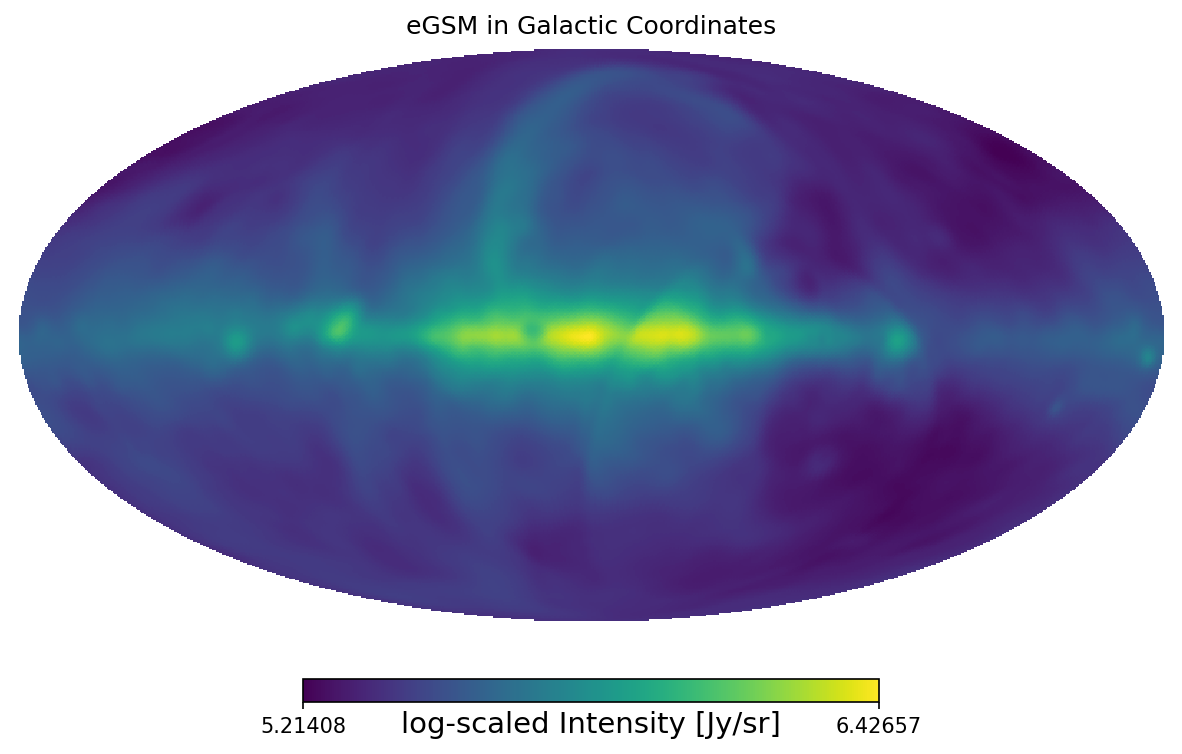

In [23]:
fig = plt.figure(figsize=(8,8), dpi=150)
healpy.mollview(
    np.log10(Isky[0].value),
    title="eGSM in Galactic Coordinates",
    unit="log-scaled Intensity [Jy/sr]",
    fig=1,
)
fig.savefig("example_egsm_map_gal_coords.png", bbox_inches='tight', dpi=150)

In [24]:
# Rotate the map to be in the same coordinate system as the beam
lat, lon, alt = uvd.telescope_location_lat_lon_alt
lst = np.unique(uvd.lst_array)[0]
rotator = healpy.rotator.Rotator(
    rot=None,
    coord=('G', 'E'),
)

# Quick check to see that the rotation actually works.
alm_egsm = healpy.map2alm(Isky[0].value)
alm_egsm_rot = alm_egsm.copy()
rotator.rotate_alm(alm_egsm_rot, inplace=True)
ecef_map = healpy.alm2map(alm_egsm_rot, nside=nside)
healpy.rotate_alm(alm_egsm_rot, 0, np.pi / 2 - lat, -lst)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 20 deg 0.00'.


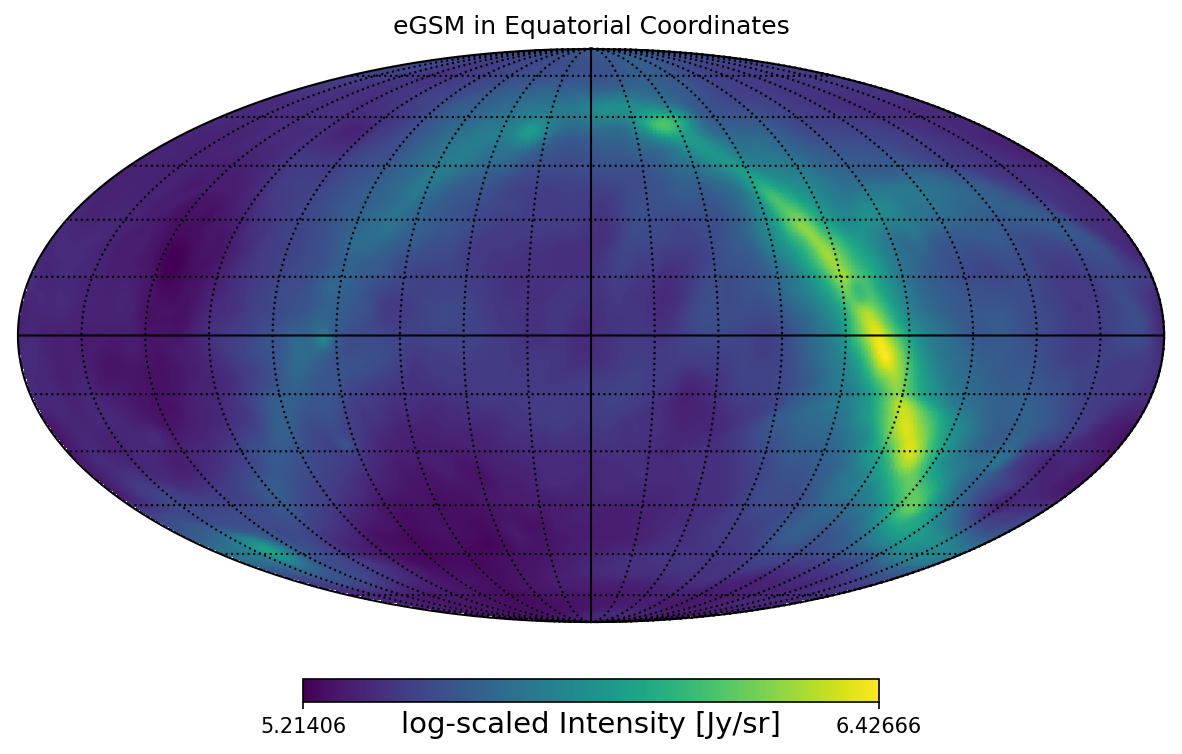

In [25]:
fig = plt.figure(figsize=(8,8), dpi=150)
healpy.mollview(
    np.log10(ecef_map),
    title="eGSM in Equatorial Coordinates",
    unit="log-scaled Intensity [Jy/sr]",
    fig=1,
)
healpy.graticule(dpar=15,dmer=20)
fig.savefig("example_egsm_eq_coords.png", bbox_inches='tight', dpi=150)

In [26]:
rot_map = healpy.alm2map(alm_egsm_rot, nside=nside)

The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


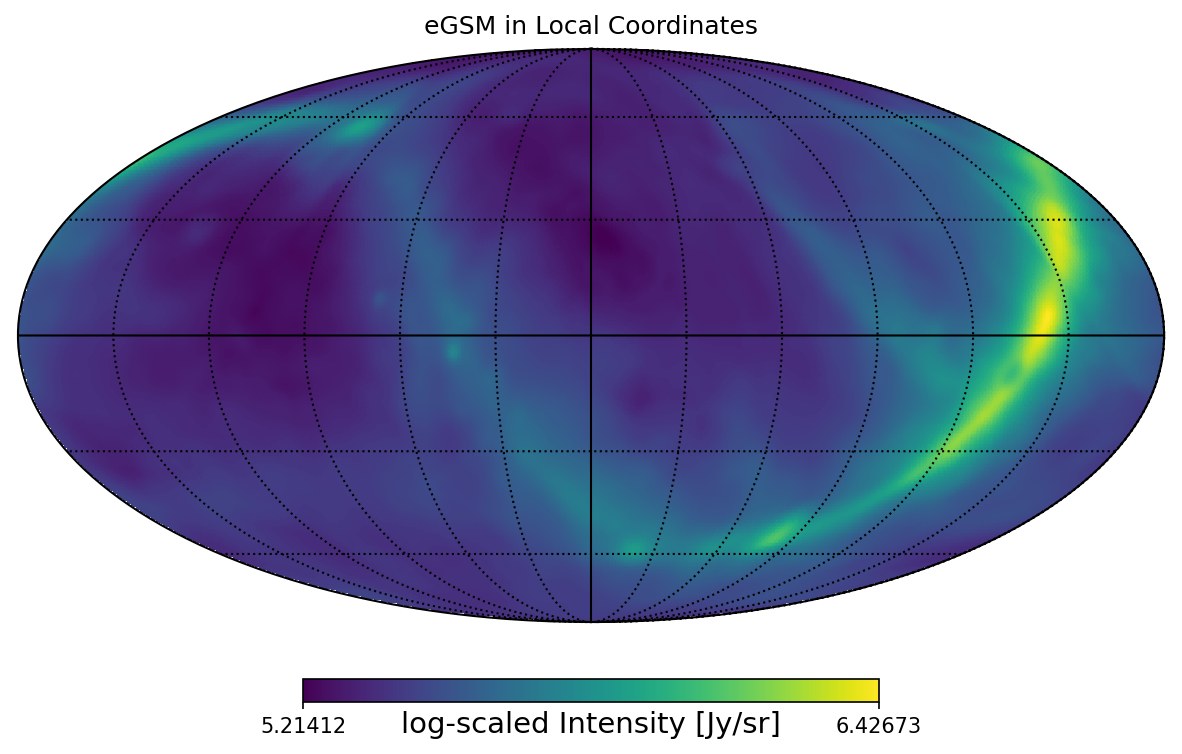

In [27]:
fig = plt.figure(figsize=(8,8), dpi=150)
healpy.mollview(
    np.log10(rot_map),
    title="eGSM in Local Coordinates",
    unit="log-scaled Intensity [Jy/sr]",
    fig=1,
)
healpy.graticule()
fig.savefig("example_egsm_local_coord.png", bbox_inches='tight', dpi=150)

In [28]:
stokes = np.zeros((4, nfreq, npix), dtype=Isky.dtype)
for i in range(nfreq):
    # Rotate each map individually
    alm = healpy.map2alm(Isky[i].value)
    rotator.rotate_alm(alm, inplace=True)
    healpy.rotate_alm(alm, 0, np.pi / 2 - lat, -lst)
    rotated_map = healpy.alm2map(alm, nside)
    stokes[0,i] = rotated_map

In [29]:
sky_model = pyradiosky.SkyModel(
    stokes=stokes * units.Jy / units.sr,
    spectral_type="subband",
    freq_array=sky_freqs,
    nside=nside,
    hpx_inds=np.arange(npix),
)

In [30]:
this_freq = uvd.freq_array[0,chan]

In [31]:
this_map = sky_model.at_frequencies(
    np.array([this_freq]) * units.Hz, inplace=False
)

In [32]:
az = sky_model.ra.value
za = np.pi / 2 - sky_model.dec.value
above_horizon = za < np.pi / 2

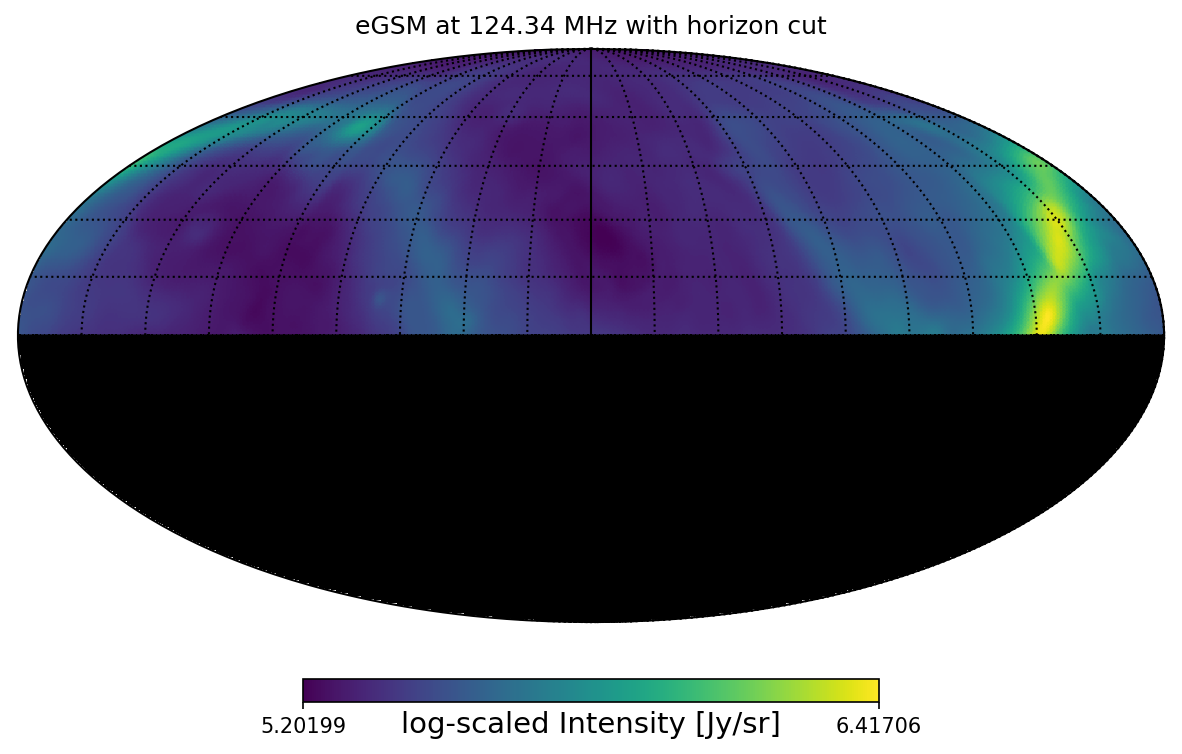

In [33]:
fig = plt.figure(figsize=(8,8), dpi=150)
plot_map = this_map.stokes[0,0].value.copy()
plot_map[~above_horizon] = np.nan
healpy.mollview(
    np.log10(plot_map),
    title=f"eGSM at {(this_freq * units.Hz).to('MHz'):.2f} with horizon cut",
    unit="log-scaled Intensity [Jy/sr]",
    fig=1,
    badcolor='k',
    bgcolor='white',
)
healpy.graticule(dpar=15,dmer=20)
fig.savefig("example_interpolated_egsm_with_hor_cut.png", bbox_inches='tight', dpi=150)

In [34]:
# We should choose the grid size so that the Fourier transform
# will include all of the uv-modes we sample with the array.
# So, let's figure that out.
# Note that spacing in the image plane is 2 / Npix, so the
# highest u-mode sampled for a plane with Npix pixels along
# a side is Npix / 4.
baselines = {}
uvws = {}
pos, ants = uvd.get_ENU_antpos()
antpos = dict(zip(ants, pos))
for antpair in uvd.get_antpairs():
    ai, aj = antpair
    baseline = antpos[aj] - antpos[ai]
    baselines[antpair] = baseline
    uvws[antpair] = this_freq * baseline / const.c.si.value
uvw_array = np.vstack(list(uvws.values()))
umax = np.abs(uvw_array[:,0]).max()
vmax = np.abs(uvw_array[:,1]).max()
Npix = int(4 * np.ceil(max(umax, vmax)))
print(umax, vmax, Npix)

33.53287560484989 31.680351763080356 136


In [35]:
lm_grid_size = Npix
l = np.linspace(-1, 1, lm_grid_size)
ell, emm = np.meshgrid(l, l, indexing="ij")

In [36]:
# Stupid way of gridding: nearest-neighbor
nsample = np.zeros(ell.shape, dtype=int)
gridded_I = np.zeros(ell.shape, dtype=float)
above_horizon = za <= np.pi / 2
for i, intensity in enumerate(this_map.stokes[0,0]):
    if ~above_horizon[i]:
        continue
    this_l = np.sin(za[i]) * np.cos(az[i])
    this_m = np.sin(za[i]) * np.sin(az[i])
    ell_dist = np.abs(ell - this_l)
    emm_dist = np.abs(emm - this_m)
    this_pixel = (ell_dist == ell_dist.min()) & (emm_dist == emm_dist.min())
    gridded_I[this_pixel] += intensity.value
    nsample[this_pixel] += 1

In [37]:
gridded_I[nsample > 0] /= nsample[nsample > 0]

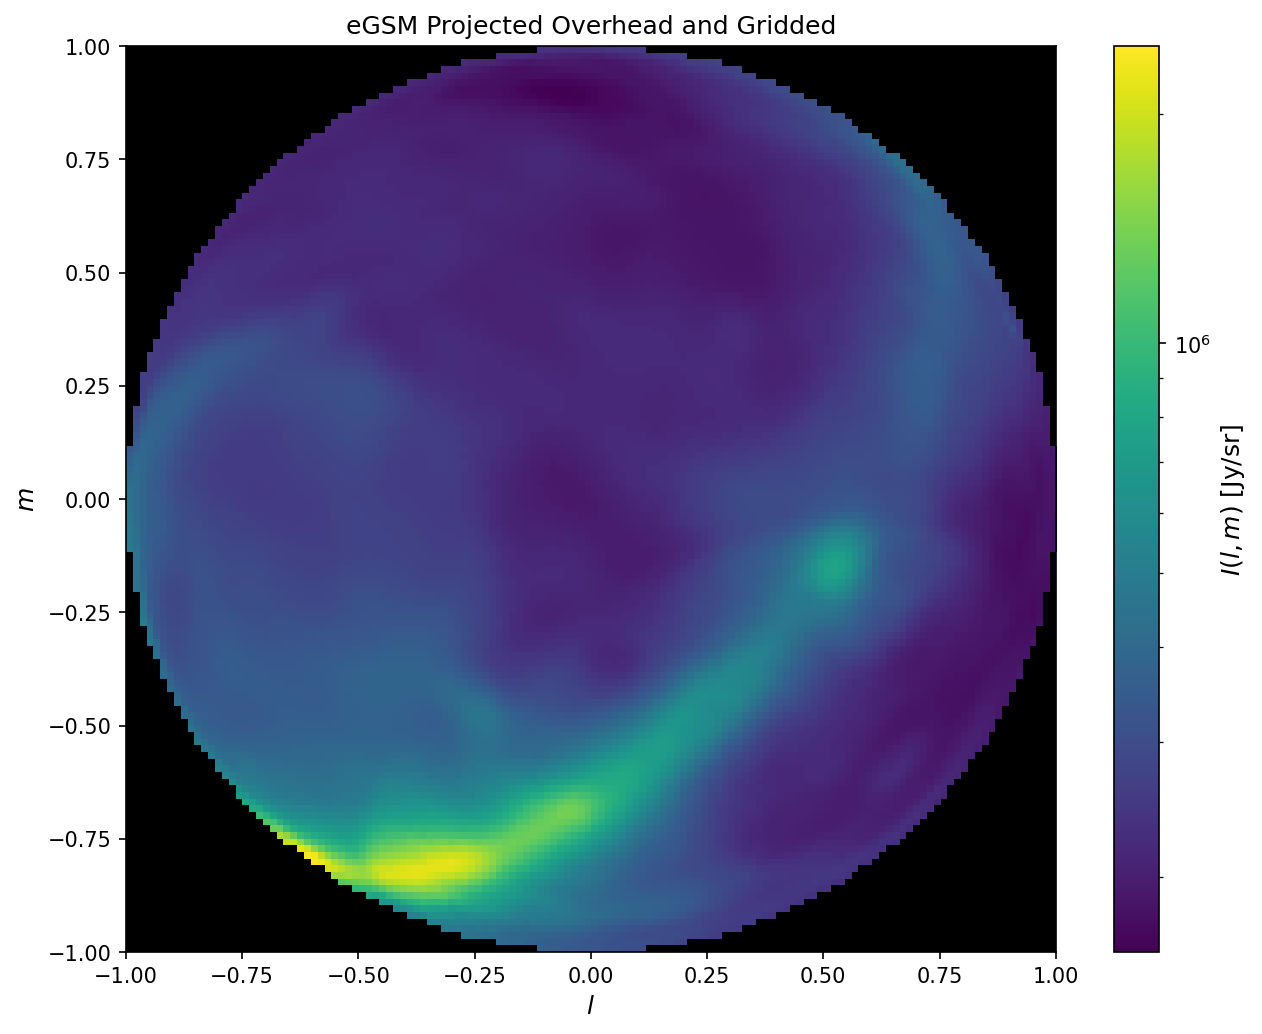

In [38]:
fig, ax = plt.subplots(
    1, 1, figsize=(10,8), subplot_kw=dict(facecolor='k'), dpi=150
)
cmap = plt.cm.viridis
norm = plt.cm.colors.LogNorm()
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cax = ax.imshow(
    gridded_I,
    origin='lower',
    aspect='auto',
    extent=(-1,1,-1,1),
    cmap=cmap,
    norm=norm,
)
ax.set_xlabel("$l$", fontsize=12)
ax.set_ylabel("$m$", fontsize=12)
ax.set_title("eGSM Projected Overhead and Gridded", fontsize=12)
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label(r"$I(l,m)$ [Jy/sr]", fontsize=12)
fig.savefig("example_gridded_sky_intensity.png", bbox_inches='tight', dpi=150)

In [39]:
# Take the 2D-FFT of I(l,m) to get c(u,v)
I_fft = np.fft.fftshift(
    np.fft.fft2(gridded_I)
) * np.mean(np.diff(l)) ** 2

In [40]:
u_samp = np.fft.fftshift(
    np.fft.fftfreq(len(l), d=np.mean(np.diff(l)))
)
umin = u_samp.min()
umax = u_samp.max()

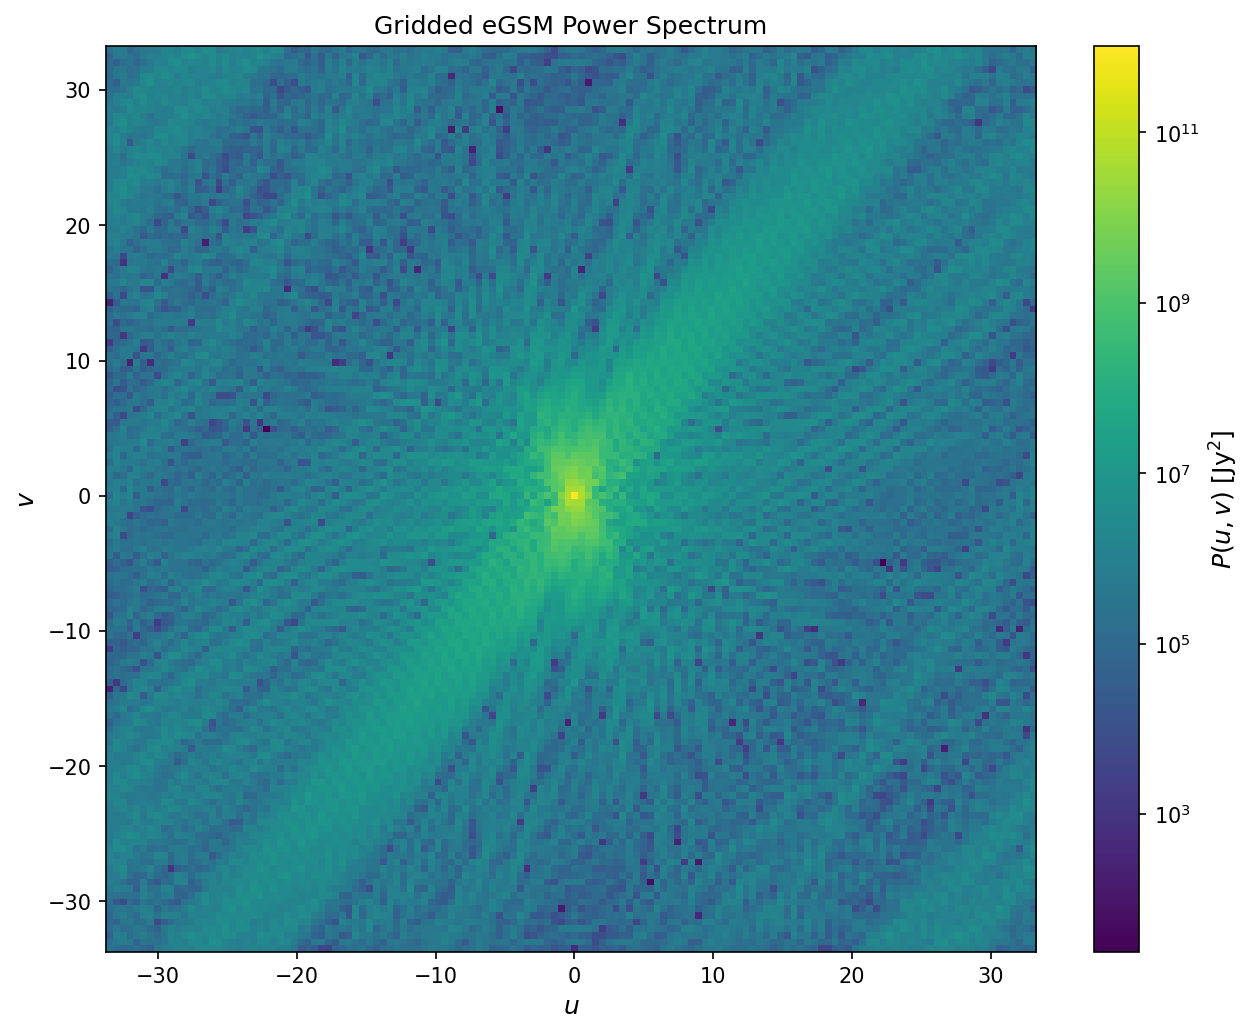

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), dpi=150)
cax = ax.imshow(
    np.abs(I_fft)**2,
    origin='lower',
    aspect='auto',
    norm=plt.cm.colors.LogNorm(),
    extent=(umin,umax,umin,umax),
)
ax.set_xlabel("$u$", fontsize=12)
ax.set_ylabel("$v$", fontsize=12)
ax.set_title(r"Gridded eGSM Power Spectrum", fontsize=12)
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label(r"$P(u,v)$ [Jy$^2$]", fontsize=12)
fig.savefig("example_gridded_power_spectrum.png", bbox_inches='tight', dpi=150)

In [168]:
test_map = np.where(np.isnan(plot_map), 0, plot_map)

In [169]:
ang_pspec = healpy.anafast(test_map)

In [173]:
ells = np.arange(ang_pspec.size)

In [179]:
u_to_ell = u_modes / (2 * np.pi)

In [181]:
ind = np.argmin(np.abs(u_to_ell - 1))

In [187]:
ang_pspec[1]/(8*np.pi)/1e9, u_modes[ind]**2 * cyl_pspec[ind]/1e9

(3.7581972221360678, 3.2492317825958383)

In [180]:
u_to_ell

array([0.        , 0.0801892 , 0.16037839, 0.24056759, 0.32075679,
       0.40094598, 0.48113518, 0.56132438, 0.64151357, 0.72170277,
       0.80189197, 0.88208116, 0.96227036, 1.04245956, 1.12264875,
       1.20283795, 1.28302715, 1.36321634, 1.44340554, 1.52359474,
       1.60378394, 1.68397313, 1.76416233, 1.84435153, 1.92454072,
       2.00472992, 2.08491912, 2.16510831, 2.24529751, 2.32548671,
       2.4056759 , 2.4858651 , 2.5660543 , 2.64624349, 2.72643269,
       2.80662189, 2.88681108, 2.96700028, 3.04718948, 3.12737867,
       3.20756787, 3.28775707, 3.36794626, 3.44813546, 3.52832466,
       3.60851385, 3.68870305, 3.76889225, 3.84908144, 3.92927064,
       4.00945984, 4.08964903, 4.16983823, 4.25002743, 4.33021663,
       4.41040582, 4.49059502, 4.57078422, 4.65097341, 4.73116261,
       4.81135181, 4.891541  , 4.9717302 , 5.0519194 , 5.13210859,
       5.21229779, 5.29248699])

In [165]:
cyl_pspec

array([1.03087190e+12, 4.49083364e+10, 1.63136246e+10, 6.49403943e+09,
       4.99798879e+09, 1.69610183e+09, 9.09284959e+08, 3.91139817e+08,
       3.58686622e+08, 2.00132419e+08, 2.21861205e+08, 1.36684386e+08,
       8.88846440e+07, 3.92918037e+07, 2.29868204e+07, 2.90458875e+07,
       2.35431930e+07, 8.06855612e+06, 7.18087474e+06, 1.25887921e+07,
       1.06064349e+07, 2.02306186e+07, 6.56937000e+06, 1.08065697e+07,
       3.64484122e+06, 1.94977828e+06, 1.06566403e+07, 1.59926486e+07,
       1.40075468e+07, 8.00096781e+05, 1.23865238e+06, 2.38623739e+06,
       7.79140411e+06, 3.39096664e+06, 1.60899840e+06, 2.44820115e+06,
       7.48073400e+05, 2.07922044e+06, 3.57906090e+06, 6.65470900e+06,
       1.04961975e+07, 6.81307027e+06, 5.44598181e+06, 1.36307758e+06,
       4.13934293e+06, 2.49284336e+05, 1.88038343e+06, 2.74669549e+06,
       6.45512540e+05, 1.62824975e+06, 1.92970763e+06, 3.54385466e+05,
       1.88407497e+06, 2.05384478e+06, 2.88301877e+06, 2.62160706e+06,
      

In [42]:
# Bin this circularly and see if the resulting power spectrum
# looks like a power law with something like 1/u^3
u_modes = np.linspace(0, umax, u_samp.size // 2 - 1)
cyl_pspec = np.zeros_like(u_modes)
full_pspec = np.abs(I_fft) ** 2
u_mesh, v_mesh = np.meshgrid(u_samp, u_samp, indexing="ij")
samp_u_modes = np.sqrt(u_mesh ** 2 + v_mesh ** 2)
for i, u in enumerate(u_modes):
    du = np.abs(u - samp_u_modes)
    cyl_pspec[i] = np.mean(full_pspec[du == du.min()])

In [43]:
log_p = np.log10(cyl_pspec[1:])
log_u = np.log10(u_modes[1:])
A = np.zeros((log_u.size, 2))
A[:,0] = log_u
A[:,1] = 1
slope, intercept = np.linalg.inv(
    A.T @ A
) @ A.T @ log_p
fit = slope * log_u + intercept
chisq = np.sum(
    (log_p - fit) ** 2
)
err = chisq * np.linalg.inv(A.T @ A) / (log_p.size - 2)

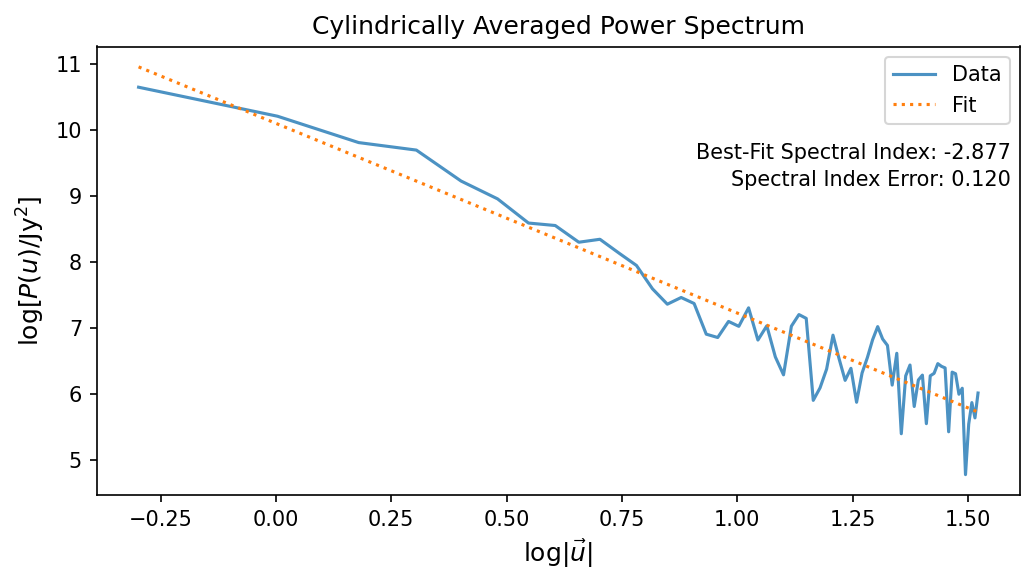

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(7,4), dpi=150)
ax.set_xlabel(r"$\log|\vec{u}|$", fontsize=12)
ax.set_ylabel(r"$\log[P(u)/{\rm Jy}^2]$", fontsize=12)
ax.set_title("Cylindrically Averaged Power Spectrum", fontsize=12)
ax.plot(log_u, log_p, label="Data", alpha=0.8)
ax.plot(log_u, fit, ls=':', label="Fit")
ax.legend(loc="upper right")
ax.text(
    0.99,
    0.75,
    f"Best-Fit Spectral Index: {slope:.3f}",
    transform=ax.transAxes,
    horizontalalignment="right",
)
ax.text(
    0.99,
    0.69,
    f"Spectral Index Error: {np.sqrt(err[0,0]):.3f}",
    transform=ax.transAxes,
    horizontalalignment="right",
)
fig.tight_layout()
fig.savefig("cylindrical_pspec_with_fit.png", bbox_inches="tight", dpi=150)

## Calculating $\tilde{A}(u,v)$ from a Beam Model

In [45]:
home = Path(os.path.expanduser('~'))
beam_path = home / "HERA/HERA-Beams/NicolasFagnoniBeams"
beam_file = beam_path / "NF_HERA_Dipole_efield_beam.fits"
assert beam_file.exists()

In [114]:
beam = UVBeam()
beam.read_beamfits(str(beam_file))
beam.interpolation_function = 'az_za_simple'
beam.freq_interp_kind = 'cubic'

In [115]:
above_horizon = za <= np.pi / 2
interp_beam = beam.efield_to_power(
    calc_cross_pols=False, inplace=False
)
interp_beam.peak_normalize()

In [116]:
# Calculate the beam at all of the azimuths/zenith angles
# that are above the horizon, at the frequency of interest,
# and select only one polarization.
interp_beam = interp_beam.interp(
    az_array=az[above_horizon],
    za_array=za[above_horizon],
    freq_array=np.array([this_freq]),
    polarizations=['xx',],
)[0][0,0,0,0]

In [117]:
gridded_beam = np.zeros(ell.shape, dtype=interp_beam.dtype)
nsample_beam = np.zeros(ell.shape, dtype=int)
for i, (_az, _za) in enumerate(zip(az[above_horizon], za[above_horizon])):
    this_l = np.sin(_za) * np.cos(_az)
    this_m = np.sin(_za) * np.sin(_az)
    ell_dist = np.abs(ell - this_l)
    emm_dist = np.abs(emm - this_m)
    this_pixel = (ell_dist == ell_dist.min()) & (emm_dist == emm_dist.min())
    gridded_beam[this_pixel] += interp_beam[i]
    nsample_beam[this_pixel] += 1

gridded_beam[nsample_beam != 0] /= nsample_beam[nsample_beam != 0]

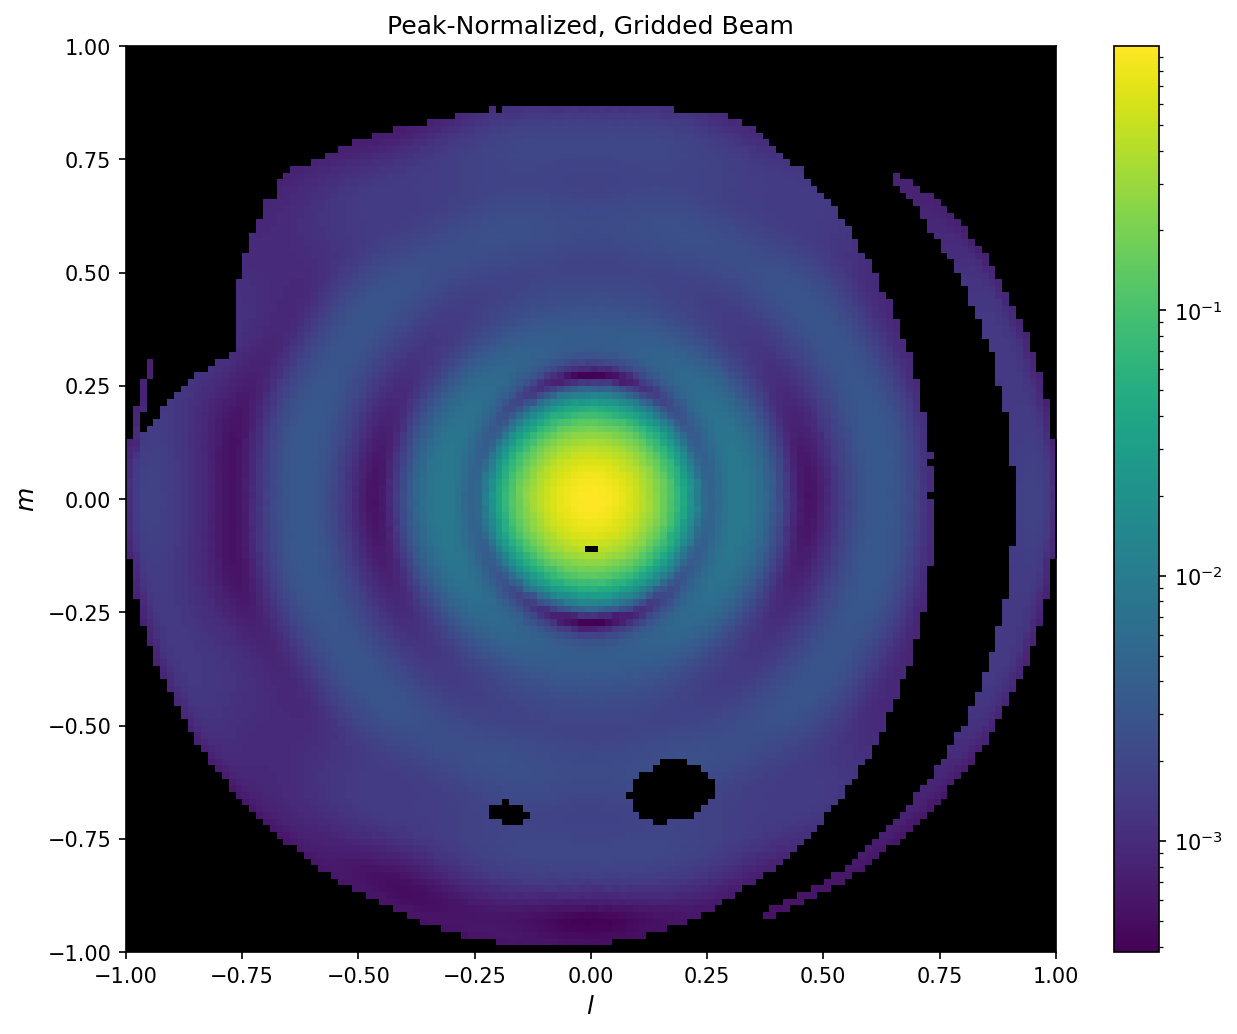

In [118]:
fig, ax = plt.subplots(
    1, 1, figsize=(10,8), subplot_kw=dict(facecolor='k'), dpi=150
)
cax = ax.imshow(
    gridded_beam,
    origin='lower',
    aspect='auto',
    norm=plt.cm.colors.LogNorm(),
    extent=(-1, 1, -1, 1),
)
fig.colorbar(cax)
ax.set_xlabel("$l$", fontsize=12)
ax.set_ylabel("$m$", fontsize=12)
ax.set_title("Peak-Normalized, Gridded Beam", fontsize=12)
fig.savefig("gridded_beam_example.png", bbox_inches='tight', dpi=150)

In [119]:
# Now get the uv kernel for the beam
beam_kernel = np.fft.fftshift(
    np.fft.fft2(gridded_beam)
) * np.mean(np.diff(l)) ** 2

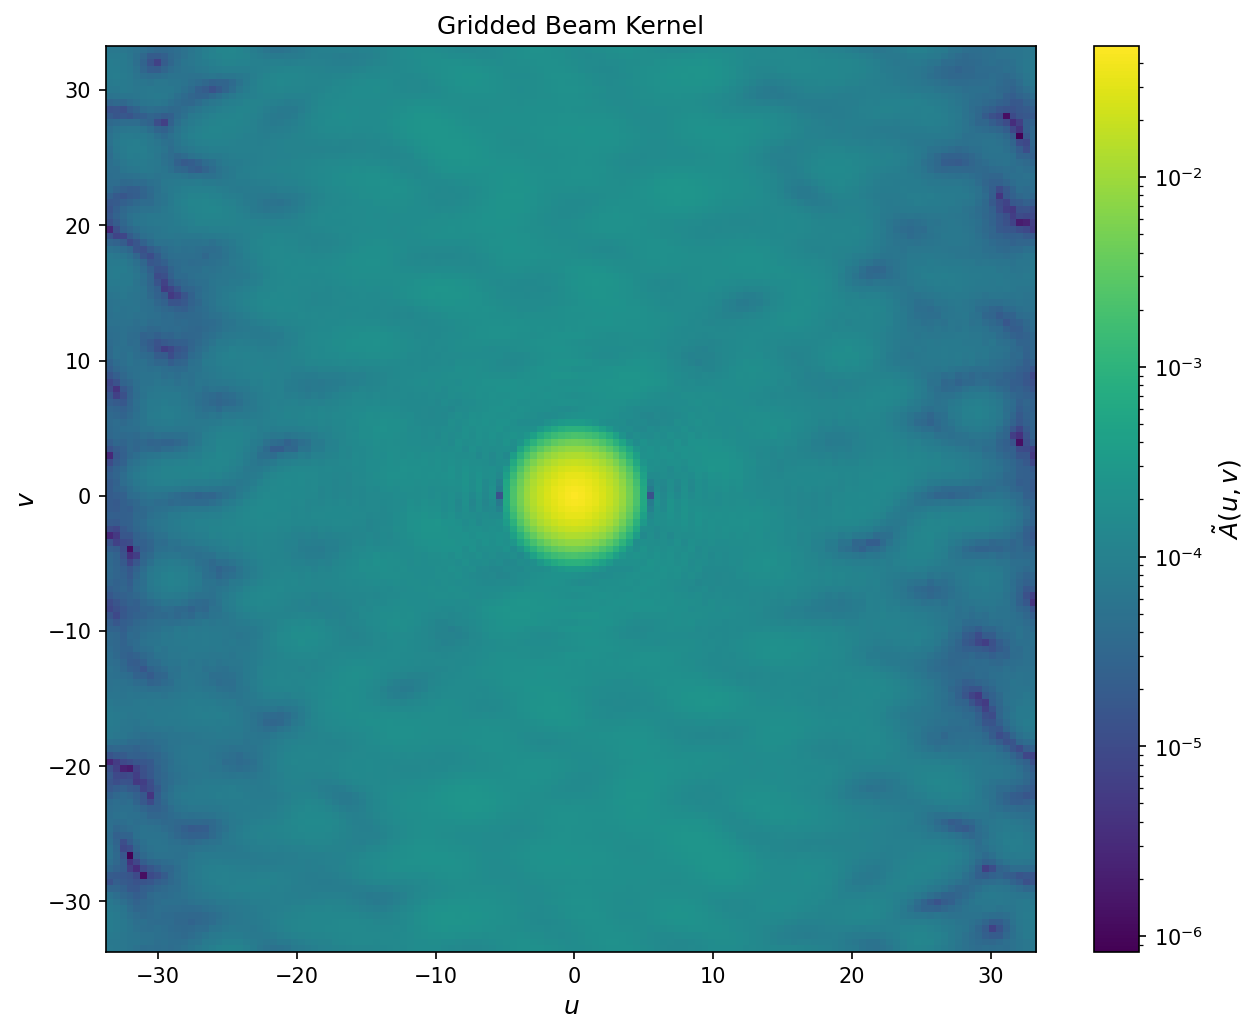

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), dpi=150)
cax = ax.imshow(
    np.abs(beam_kernel),
    origin='lower',
    aspect='auto',
    norm=plt.cm.colors.LogNorm(),
    extent=(umin,umax,umin,umax),
)
ax.set_xlabel("$u$", fontsize=12)
ax.set_ylabel("$v$", fontsize=12)
ax.set_title(r"Gridded Beam Kernel", fontsize=12)
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label(r"$\tilde{A}(u,v)$", fontsize=12)
fig.savefig("example_gridded_beam_kernel.png", bbox_inches='tight', dpi=150)

In [121]:
# Let's look at the cylindrical beam kernel
cyl_kernel = np.zeros_like(u_modes)
for i, u in enumerate(u_modes):
    du = np.abs(u - samp_u_modes)
    cyl_kernel[i] = np.abs(
        np.mean(beam_kernel[du == du.min()])
    )

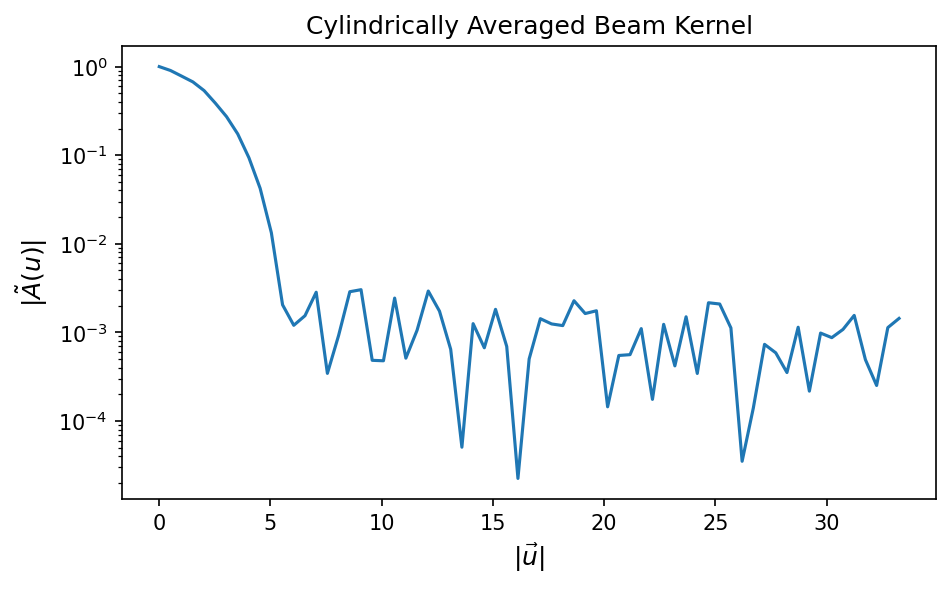

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(7,4), dpi=150)
ax.set_xlabel(r"$|\vec{u}|$", fontsize=12)
ax.set_ylabel(r"$|\tilde{A}(u)|$", fontsize=12)
ax.set_title("Cylindrically Averaged Beam Kernel", fontsize=12)
ax.semilogy(u_modes, cyl_kernel/cyl_kernel.max());

In [123]:
kernel_radius = u_modes[cyl_kernel < 1e-3 * cyl_kernel.max()][0]
kernel_mask = samp_u_modes > 3 * kernel_radius

In [56]:
# TODO: run an experiment to see if the uv kernels have less
# artifacts from edge effects when updating the gridding
# algorithm to fully fill in the image plane (rather than
# just doing the naive horizon cut).
# Another alternative is to make a 2d smoothing kernel and
# use that for calculating the FFT.

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


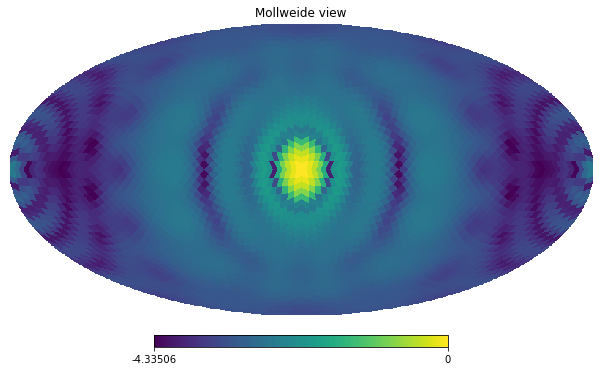

In [57]:
# Look at the beam in a Mollweide Projection
hpx_beam = beam.to_healpix(nside=2**4, inplace=False)
hpx_beam.efield_to_power()
hpx_beam.peak_normalize()
healpy.mollview(np.log10(np.abs(hpx_beam.data_array[0,0,0,50])), rot=(0,90,0))

## Calculating $\Sigma_{pq}^{\rm diff}$

The sky covariance from diffuse emission can be written as
  
$$
\Sigma_{pq}^{\rm diff} = \sum_{u,v} P(u,v) \tilde{A}(u-u_p, v-v_p) \tilde{A}^*(u-u_q, v-v_q),
$$
  
which we can calculate directly from the previously calculated quantities. In the perfectly-redundant limit, we can actually just convolve the power spectrum with the beam power.

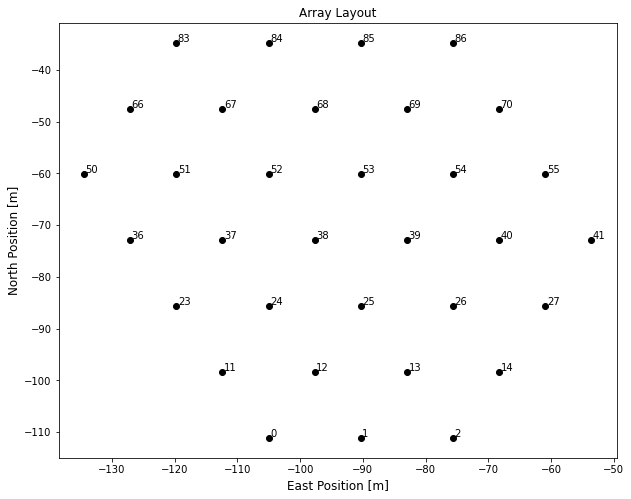

In [58]:
from hera_sim import Simulator
sim = Simulator(data=uvd)
sim.plot_array();

In [59]:
# Just do the sum. Or, calculate the beam squared, then convolve
# this with the power spectrum using the convolution theorem and
# evaluate it at the (u,v) modes sampled by each redundant group.
sky_pspec = np.abs(I_fft) ** 2
sky_delta = I_fft.real ** 2 - I_fft.imag ** 2

In [60]:
sort, edges, conj = corrcal.gridding.make_redundant_groups(*uvw_array.T[:2])
antpairs = np.array(list(uvws.keys()))
sorted_antpairs = antpairs[sort]
sorted_antpairs[conj] = sorted_antpairs[conj][::-1]
sorted_uvws = uvw_array[sort,:]
sorted_uvws[conj,:] *= -1

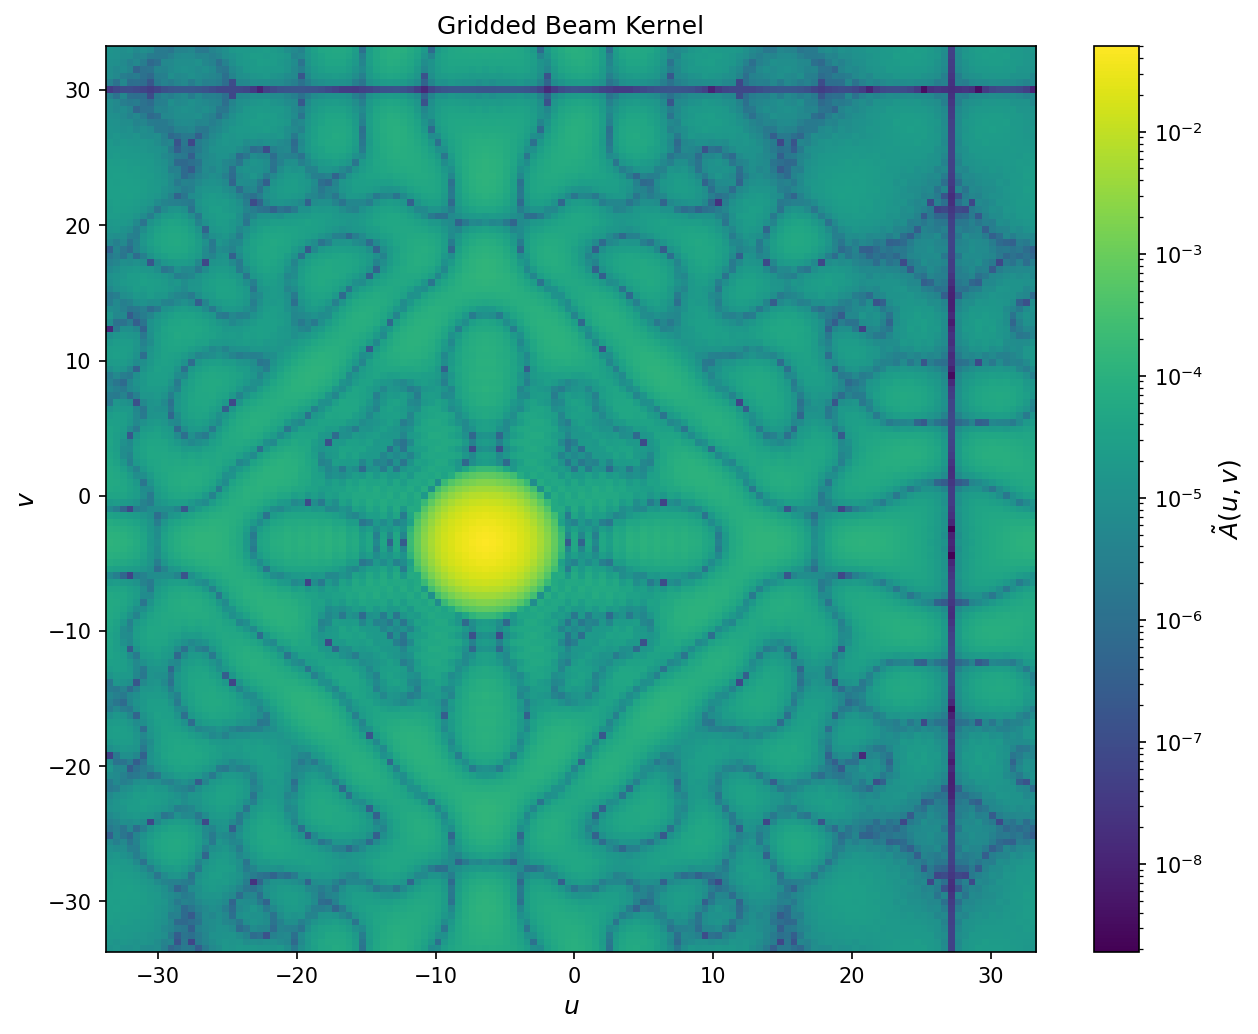

In [61]:
shifted_beam = np.roll(beam_kernel, (-7, -13), (0, 1))
fig, ax = plt.subplots(1, 1, figsize=(10,8), dpi=150)
cax = ax.imshow(
    np.abs(shifted_beam),
    origin='lower',
    aspect='auto',
    norm=plt.cm.colors.LogNorm(),
    extent=(umin,umax,umin,umax),
)
ax.set_xlabel("$u$", fontsize=12)
ax.set_ylabel("$v$", fontsize=12)
ax.set_title(r"Gridded Beam Kernel", fontsize=12)
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label(r"$\tilde{A}(u,v)$", fontsize=12)

In [62]:
import time

In [63]:
diag = np.zeros(uvd.Nbls, dtype=float)
ref = np.argmin(np.abs(u_samp))
for i, (ai, aj) in enumerate(antpairs):
    u, v = sorted_uvws[i,:2]
    du = np.abs(u_samp - u)
    dv = np.abs(u_samp - v)
    uv_shift = (
        np.argmin(du) - ref,
        np.argmin(dv) - ref
    )
    shifted_beam = np.roll(beam_kernel, uv_shift, axis=(0,1))
    diag[i] = np.sum(sky_pspec * np.abs(shifted_beam) ** 2)

In [64]:
sky_cov = np.zeros((uvd.Nbls, uvd.Nbls), dtype=complex)
sky_pseudocov = np.zeros((uvd.Nbls, uvd.Nbls), dtype=complex)
t1 = time.time()
for i, antpair1 in enumerate(antpairs):
    for j, antpair2 in enumerate(antpairs):
        u1, v1 = sorted_uvws[i,:2]
        u2, v2 = sorted_uvws[j,:2]
        du1 = np.abs(u_samp - u1)
        dv1 = np.abs(u_samp - v1)
        du2 = np.abs(u_samp - u2)
        dv2 = np.abs(u_samp - v2)
        uv1_shift = np.array([np.argmin(du1), np.argmin(dv1)], dtype=int) - ref
        uv2_shift = np.array([np.argmin(du2), np.argmin(dv2)], dtype=int) - ref
        beam_1 = np.roll(beam_kernel, uv1_shift, axis=(0, 1))
        beam_2 = np.roll(beam_kernel, uv2_shift, axis=(0, 1))
        sky_cov[i,j] = np.sum(sky_pspec * beam_1 * beam_2.conj())
        beam_1 = np.roll(beam_kernel, -uv1_shift, axis=(0,1))
        beam_2 = np.roll(beam_kernel, -uv2_shift, axis=(0,1))
        sky_pseudocov[i,j] = np.sum(sky_delta * beam_1 * beam_2)
t2 = time.time()
print(f"Took {(t2 - t1) / 60:.2f} minutes.")

Took 2.38 minutes.


In [65]:
Nbls = uvd.Nbls
full_cov = np.zeros((2*Nbls, 2*Nbls), dtype=float)
full_cov[:Nbls,:Nbls] = 0.5 * np.real(sky_cov + sky_pseudocov)
full_cov[:Nbls,Nbls:] = 0.5 * np.imag(sky_pseudocov - sky_cov)
full_cov[Nbls:,:Nbls] = 0.5 * np.imag(sky_cov + sky_pseudocov)
full_cov[Nbls:,Nbls:] = 0.5 * np.real(sky_cov - sky_pseudocov)

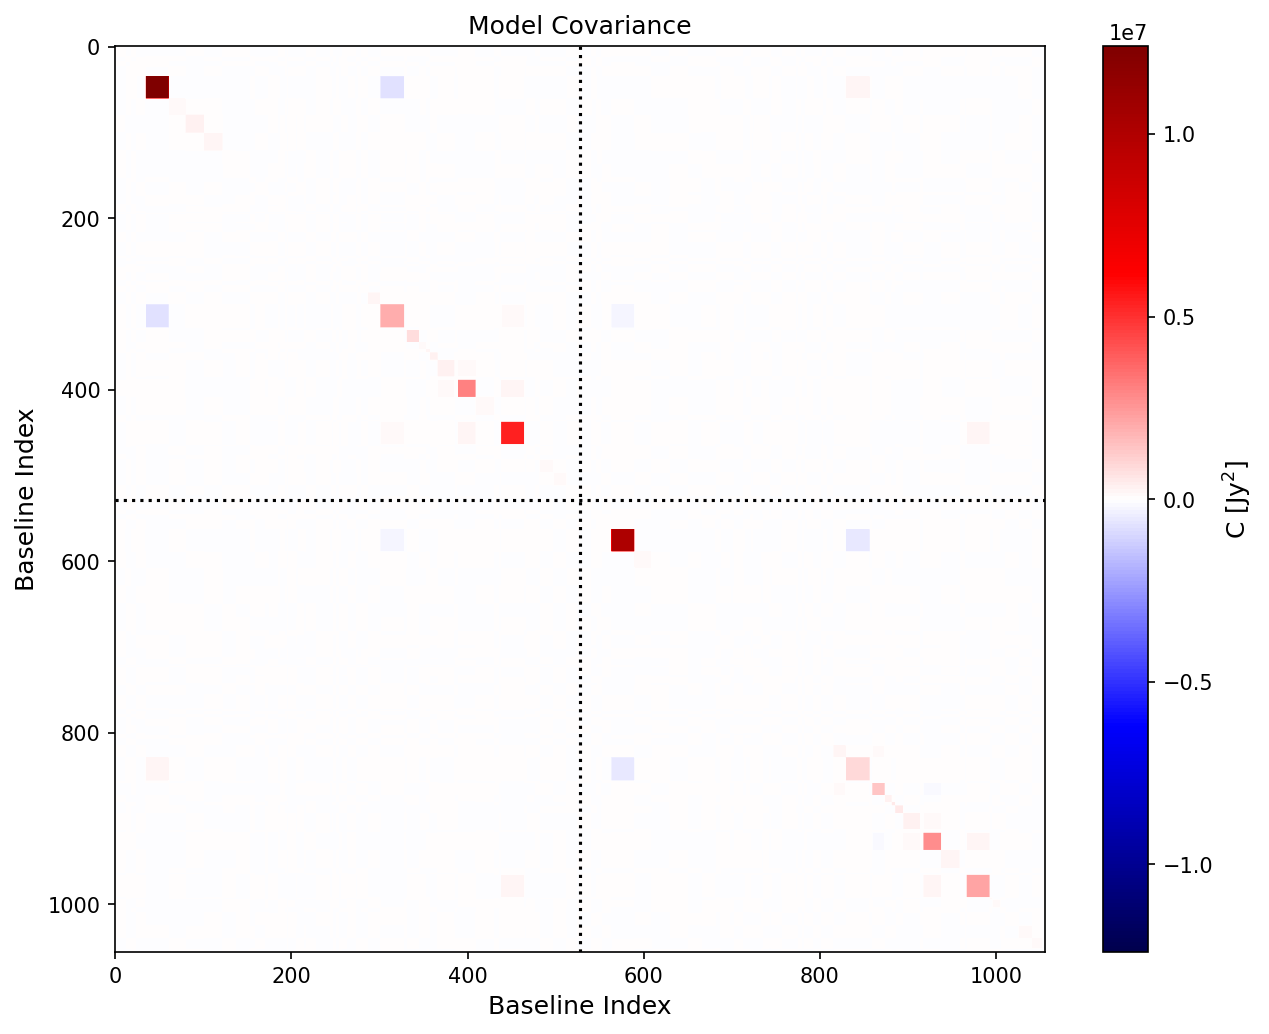

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), dpi=150)
cax = ax.imshow(full_cov, aspect='auto', cmap='seismic', vmin=-full_cov.max(), vmax=full_cov.max())
cbar = fig.colorbar(cax)
ax.set_title("Model Covariance", fontsize=12)
cbar.set_label("C [Jy$^2$]", fontsize=12)
ax.set_xlabel("Baseline Index", fontsize=12)
ax.set_ylabel("Baseline Index", fontsize=12)
ax.axhline(Nbls, ls=':', color='k')
ax.axvline(Nbls, ls=':', color='k')
fig.savefig("example_model_covariance.png", bbox_inches='tight', dpi=150)

Text(0.5, 1.0, 'Imaginary Pseudo-Covariance')

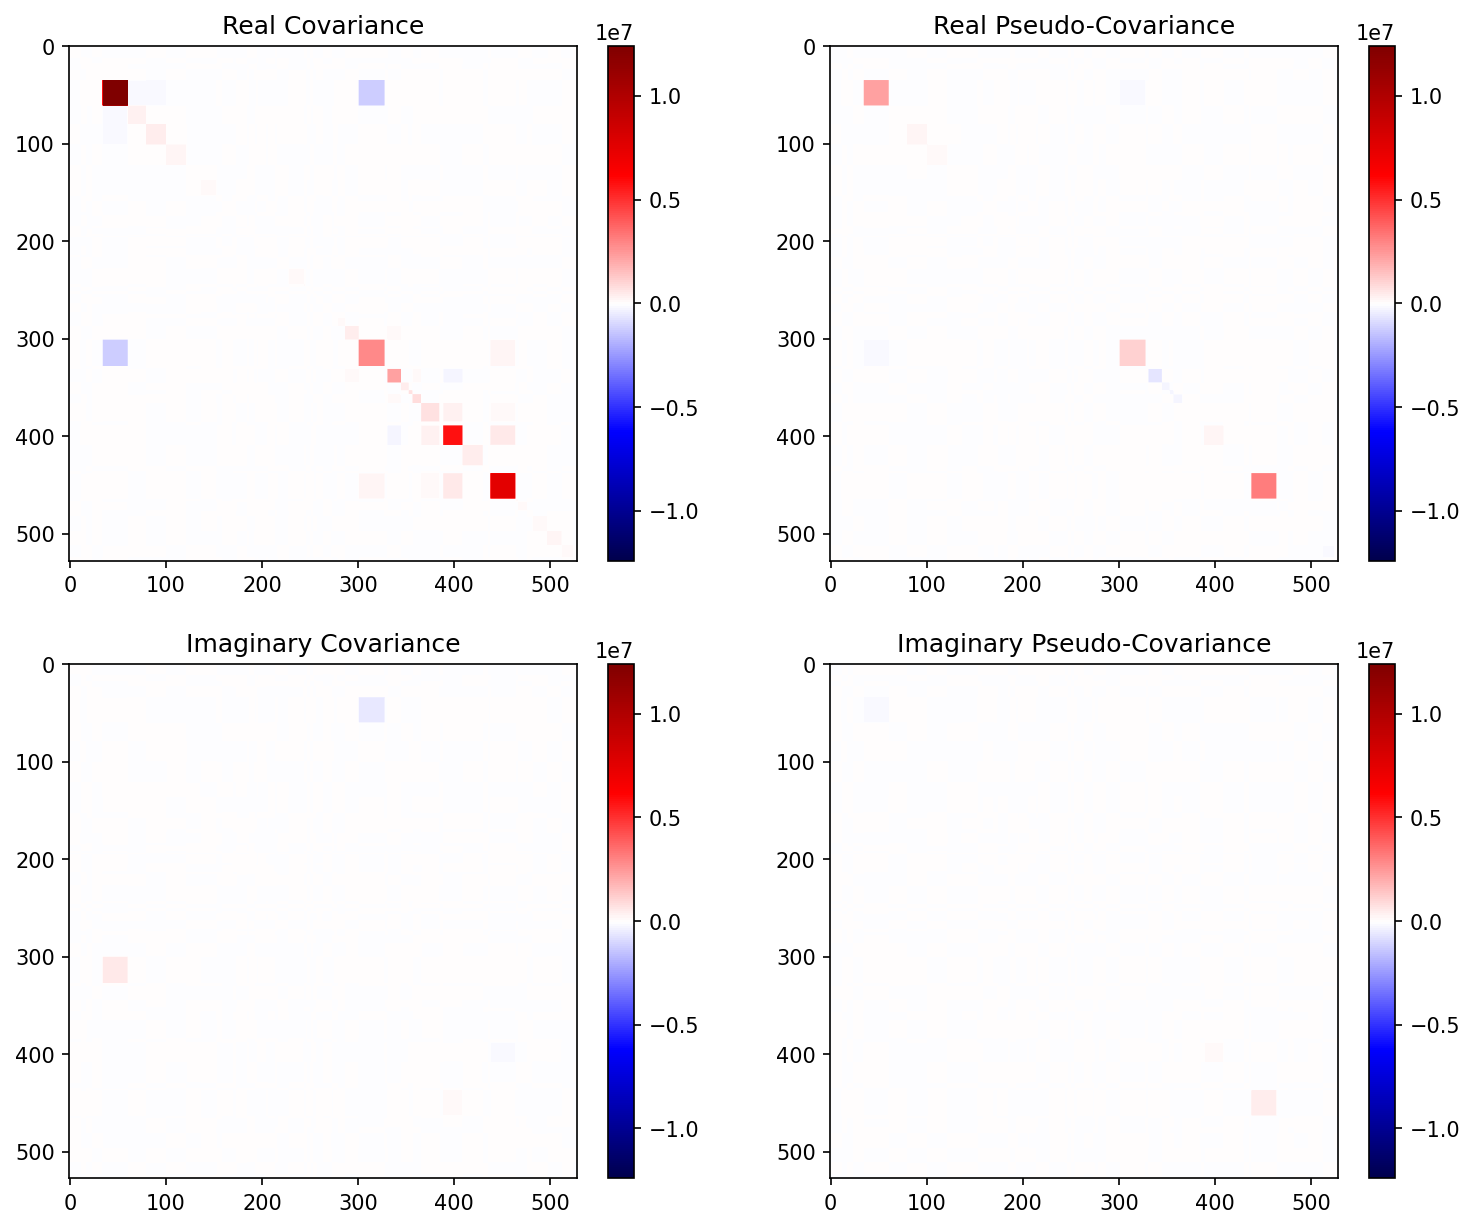

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(12,10), dpi=150)
cax = axes[0,0].imshow(sky_cov.real, aspect='auto', cmap='seismic', vmin=-full_cov.max(), vmax=full_cov.max())
cbar = fig.colorbar(cax, ax=axes[0,0])
cax = axes[0,1].imshow(sky_pseudocov.real, aspect='auto', cmap='seismic', vmin=-full_cov.max(), vmax=full_cov.max())
cbar = fig.colorbar(cax, ax=axes[0,1])
cax = axes[1,0].imshow(sky_cov.imag, aspect='auto', cmap='seismic', vmin=-full_cov.max(), vmax=full_cov.max())
cbar = fig.colorbar(cax, ax=axes[1,0])
cax = axes[1,1].imshow(sky_pseudocov.imag, aspect='auto', cmap='seismic', vmin=-full_cov.max(), vmax=full_cov.max())
cbar = fig.colorbar(cax, ax=axes[1,1])
axes[0,0].set_title("Real Covariance")
axes[0,1].set_title("Real Pseudo-Covariance")
axes[1,0].set_title("Imaginary Covariance")
axes[1,1].set_title("Imaginary Pseudo-Covariance")

In [68]:
eigvals, eigvecs = np.linalg.eigh(full_cov)

In [69]:
eigvals = eigvals[::-1]
eigvecs = eigvecs[:,::-1]

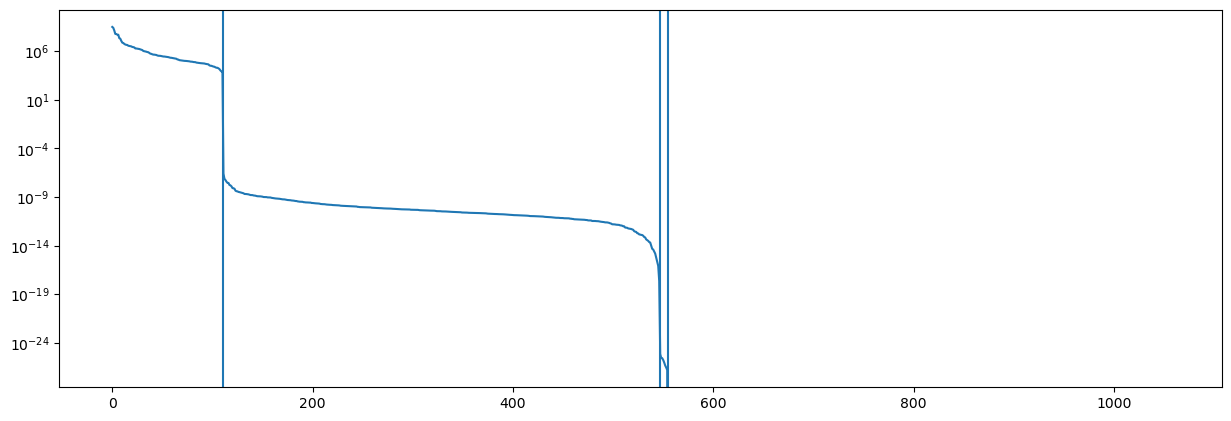

In [70]:
plt.figure(figsize=(15,5),dpi=100)
plt.semilogy(eigvals)
skip = 1
ratios = eigvals[::skip][1:] / eigvals[::skip][:-1]
inds = skip * (np.argwhere(ratios < 1e-3).flatten() + 1)
for ind in inds:
    plt.axvline(ind)

In [71]:
neig = inds[0]
small_eigs = eigvals[:neig]
small_eigvecs = eigvecs[:,:neig]

In [72]:
out = small_eigvecs @ np.diag(small_eigs) @ small_eigvecs.T

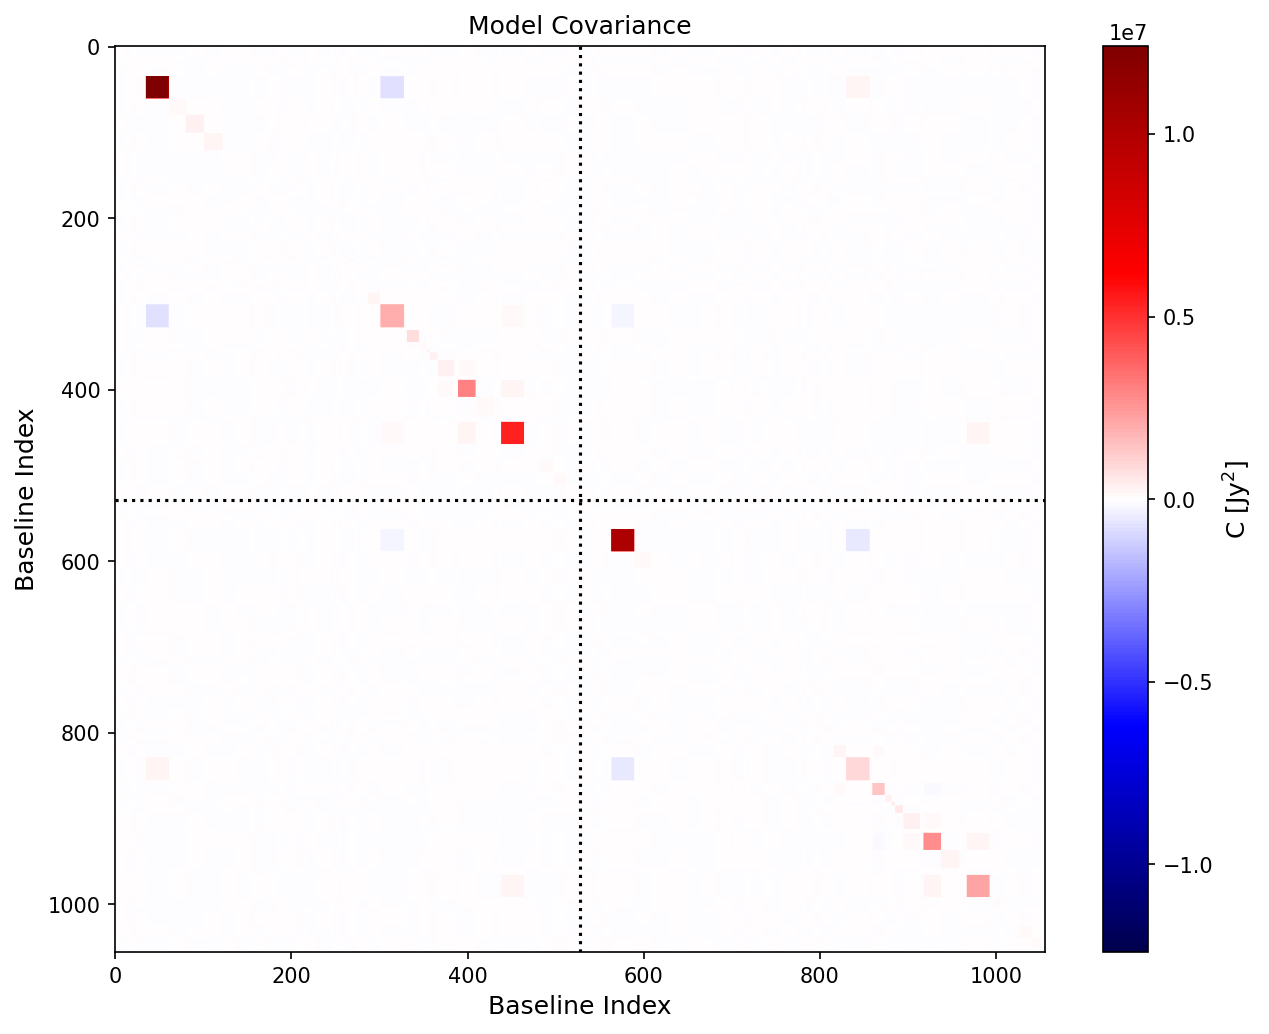

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), dpi=150)
cax = ax.imshow(out, aspect='auto', cmap='seismic', vmin=-full_cov.max(), vmax=full_cov.max())
cbar = fig.colorbar(cax)
ax.set_title("Model Covariance", fontsize=12)
cbar.set_label("C [Jy$^2$]", fontsize=12)
ax.set_xlabel("Baseline Index", fontsize=12)
ax.set_ylabel("Baseline Index", fontsize=12)
ax.axhline(Nbls, ls=':', color='k')
ax.axvline(Nbls, ls=':', color='k')
fig.savefig(f"example_reconstructed_model_covariance_{neig}_eigvals.png", bbox_inches='tight', dpi=150)

### Investigating Edge Effects

This section will repeat what was performed in the previous section, but use a masked version of the beam kernel, where everything outside some multiple of the main lobe radius is zeroed out.

In [74]:
# # First, let's look at the mask just because.
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.set_xlabel("$u$", fontsize=12)
# ax.set_ylabel("$v$", fontsize=12)
# ax.set_title("Low-Pass Mask", fontsize=12)
# ax.imshow(kernel_mask, aspect='equal', extent=(umin, umax, umin, umax), origin="lower");`

In [75]:
# masked_kernel = beam_kernel.copy()
# masked_kernel[kernel_mask] = 0

In [76]:
# ref = np.argwhere(
#     np.abs(u_samp) == np.abs(u_samp).min()  # In case we don't actually hit 0
# ).flatten()[0]
# sky_cov_alt = np.zeros((uvd.Nbls, uvd.Nbls), dtype=complex)
# sky_pseudocov_alt = np.zeros((uvd.Nbls, uvd.Nbls), dtype=complex)
# t1 = time.time()
# for i, antpair1 in enumerate(antpairs):
#     for j, antpair2 in enumerate(antpairs):
#         u1, v1 = sorted_uvws[i,:2]
#         u2, v2 = sorted_uvws[j,:2]
#         du1 = np.abs(u_samp - u1)
#         dv1 = np.abs(u_samp - v1)
#         du2 = np.abs(u_samp - u2)
#         dv2 = np.abs(u_samp - v2)
#         uv1_shift = np.array(  # Turn this little routine into a function.
#             [
#                 np.argwhere(du1 == du1.min())[0][0] - ref,
#                 np.argwhere(dv1 == dv1.min())[0][0] - ref,
#             ]
#         )
#         uv2_shift = np.array(
#             [
#                 np.argwhere(du2 == du2.min())[0][0] - ref,
#                 np.argwhere(dv2 == dv2.min())[0][0] - ref,
#             ]
#         )
#         beam_1 = np.roll(masked_kernel, uv1_shift, axis=(0, 1))
#         beam_2 = np.roll(masked_kernel, uv2_shift, axis=(0, 1))
#         sky_cov_alt[i,j] = np.sum(sky_pspec * beam_1 * beam_2.conj())
#         beam_1 = np.roll(masked_kernel, -uv1_shift, axis=(0,1))
#         beam_2 = np.roll(masked_kernel, -uv2_shift, axis=(0,1))
#         sky_pseudocov_alt[i,j] = np.sum(sky_delta * beam_1 * beam_2)
# t2 = time.time()
# print(f"Took {(t2 - t1) / 60:.2f} minutes.")

In [77]:
# Nbls = uvd.Nbls
# full_cov_alt = np.zeros((2*Nbls, 2*Nbls), dtype=float)
# full_cov_alt[:Nbls,:Nbls] = np.real(sky_cov_alt + sky_pseudocov_alt)
# full_cov_alt[:Nbls,Nbls:] = np.imag(sky_pseudocov_alt - sky_cov_alt)
# full_cov_alt[Nbls:,:Nbls] = np.imag(sky_cov_alt + sky_pseudocov_alt)
# full_cov_alt[Nbls:,Nbls:] = np.real(sky_cov_alt - sky_pseudocov_alt)

In [78]:
# fig, ax = plt.subplots(1, 1, figsize=(10,8), dpi=150)
# cax = ax.imshow(
#     full_cov_alt,
#     aspect='auto',
#     cmap='seismic',
#     vmin=-np.abs(full_cov_alt).max(),
#     vmax=np.abs(full_cov_alt).max(),
# )
# cbar = fig.colorbar(cax)
# ax.set_title("Model Covariance", fontsize=12)
# cbar.set_label("C [Jy$^2$]", fontsize=12)
# ax.set_xlabel("Baseline Index", fontsize=12)
# ax.set_ylabel("Baseline Index", fontsize=12)
# ax.axhline(Nbls, ls=':', color='k')
# ax.axvline(Nbls, ls=':', color='k')
# fig.savefig("example_model_covariance_masked_beam.png", bbox_inches='tight', dpi=150)

## Adding Noise for Invertibility

### Update
I'll be igonring this section, since the noiseless case isn't well-handled by the CorrCal formalism, and real measurements will always have noise.

The perfectly redundant covariance is not invertible, so we need to add noise in order to ensure that the covariance is invertible. As a first jab, this should be approached by taking the eigenspectrum of the covariance and finding the most negative eigenvalue&mdash;this sets the lowest possible noise level that can be added to ensure stable (I hope) inversion of the covariance. In order to be convinced that this is a stable solution, some tests should be performed that gradually decrease the noise level down to this limit and demonstrate convergence. As an extra proof-of-concept type thing, the noise level could be further decreased to show that it does indeed become unstable after this threshold noise level.

In [79]:
# # Calculate the eigenvalues for the covariance
# full_cov_eigspec = np.linalg.eigvalsh(full_cov)[::-1]

# # Find the minimum eigenvalue
# desired_condition_numbers = np.logspace(10, -2, 50)
# noise_levels = full_cov_eigspec[0] / desired_condition_numbers
# inverse_covariances = np.zeros(
#     (noise_levels.size,) + full_cov.shape, dtype=float
# )
# condition_numbers = np.zeros_like(desired_condition_numbers)
# for i, noise_level in enumerate(noise_levels):
#     this_cov = full_cov + noise_level * np.eye(full_cov.shape[0])
#     inverse_covariances[i] = np.linalg.inv(this_cov)
#     eigvals = np.linalg.eigvalsh(this_cov)[::-1]
#     condition_numbers[i] = np.abs(eigvals[0] / eigvals[-1])

In [80]:
# plt.plot(full_cov_eigspec)

In [81]:
# minvals = [np.min(cinv) for cinv in inverse_covariances]
# maxvals = [np.max(cinv) for cinv in inverse_covariances]

In [82]:
# plt.figure(figsize=(10,8))
# plt.loglog(noise_levels, np.abs(minvals), label='abs(min)')
# plt.loglog(noise_levels, maxvals, label='max')
# plt.legend()

In [83]:
# fig, axes = plt.subplots(
#     nrows=10,
#     ncols=5,
#     figsize=(20,35),
#     dpi=200,
# )
# vmax = np.max(inverse_covariances[-1])
# vmin = np.min(inverse_covariances[-1])
# norm = plt.cm.colors.Normalize(vmin=vmin, vmax=vmax)
# cmap = plt.cm.viridis
# smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
# for i, cinv in enumerate(inverse_covariances):
#     ax = axes.flatten()[i]
#     title = f"Noise Amplitude: {noise_levels[i]:.3e}"
#     title += f"\nCondition Number: {condition_numbers[i]:.2e}"
#     ax.set_title(title, fontsize=12)
#     ax.imshow(
#         cinv, aspect='auto', norm=norm, cmap=cmap
#     )
# fig.tight_layout()
# for row in axes:
#     fig.colorbar(mappable=smap, ax=row, pad=0.01)

In [84]:
# split_data = np.zeros(2 * Nbls, dtype=float)
# split_data[:Nbls] = data.real
# split_data[Nbls:] = data.imag

In [85]:
# chisq_vals = np.zeros_like(noise_levels)
# for i, cinv in enumerate(inverse_covariances):
#     chisq_vals[i] = split_data @ cinv @ split_data

In [86]:
# fig, ax = plt.subplots(1, 1, figsize=(10,4), dpi=150)
# ax.loglog(noise_levels, chisq_vals)
# ax.set_xlabel("Noise Variance [Jy$^2$]", fontsize=12)
# ax.set_ylabel("$\chi^2$", fontsize=12)

In [63]:
# Add some realistic noise
this_time = uvd.time_array[uvd.lst_array==lst][0]
uvdata_autos = UVData()
uvdata_autos.read(
    test_file,
    ant_str='auto',
    times=np.array([this_time]),
    freq_chans=np.array([chan]),
)
autovis = uvdata_autos.get_data(0,0,'xx')[0,0].real

Telescope RIMEz calculation is not in known_telescopes.


In [64]:
# Need to get the beam area, so
hpx_beam = beam.interp(freq_array=np.array([this_freq]), new_object=True)
hpx_beam.efield_to_power(calc_cross_pols=False)
hpx_beam.select(polarizations=np.array([-5,]))
hpx_beam.to_healpix(nside=2**4)
hpx_beam.peak_normalize()

In [65]:
omega_p = hpx_beam.get_beam_area(pol="xx")
Jy2T = jansky_to_kelvin(freqs=this_freq / 1e9, omega_p=omega_p)
Trx = 100
rx_vis = Trx / Jy2T
inttime = uvd.integration_time[0]
channel_width = uvd.channel_width
# This is the noise variance according to the radiometer equation
noise_variance = (autovis + rx_vis) ** 2 / (inttime * channel_width)

In [66]:
this_uvdata = UVData()
this_uvdata.read(
    test_file,
    polarizations=np.array([-5]),
)

Telescope RIMEz calculation is not in known_telescopes.


In [67]:
import hera_sim
hera_sim.defaults.set("h1c")
sim = Simulator(data=this_uvdata.copy())
sim.add("thermal_noise", seed="initial", Trx=100, omega_p=omega_p)
# sim.add("gains", seed="once")
# sim_gains = sim.get("gains")
# sim_gains = np.array(list(sim_gains.values()))[:,chan]

In [68]:
sim.data.select(
    times=np.array([this_time]),
    freq_chans=np.array([chan]),
    ant_str='cross',
)

In [69]:
this_uvdata.select(
    times=np.array([this_time]),
    freq_chans=np.array([chan]),
    ant_str="cross",
)

In [73]:
all_bls = this_uvdata.get_antpairs()
bls_to_keep = []
for bl in all_bls:
    ai, aj = bl
    bl_vec = antpos[aj] - antpos[ai]
    if np.linalg.norm(bl_vec) > 20:
        bls_to_keep.append(bl)

In [75]:
this_uvdata.select(bls=bls_to_keep)

In [77]:
sim.data.select(bls=bls_to_keep)

In [86]:
np.allclose(sim.data.ant_1_array, this_uvdata.ant_1_array)

True

In [80]:
Nbls = this_uvdata.Nbls
this_antpairs = np.zeros((Nbls,2), dtype=int)
this_antpairs[:,0] = sim.data.ant_1_array
this_antpairs[:,1] = sim.data.ant_2_array
this_ant_1_inds = np.zeros(Nbls, dtype=int)
this_ant_2_inds = np.zeros(Nbls, dtype=int)
for i, ant in enumerate(antpos.keys()):
    this_ant_1_inds[this_antpairs[:,0]==ant] = i
    this_ant_2_inds[this_antpairs[:,1]==ant] = i
this_antpos = np.vstack(list(antpos.values()))
this_uvws = this_antpos[this_ant_2_inds,:] - this_antpos[this_ant_1_inds,:]
this_uvws *= this_freq / const.c.si.value
sort, edges, conj = corrcal.gridding.make_redundant_groups(*this_uvws.T[:2])
this_antpairs = this_antpairs[sort]
this_antpairs[conj,:] = this_antpairs[conj,::-1]
this_uvws = this_uvws[sort]
this_uvws[conj] *= -1
this_data = sim.data.data_array[:,0,0,0][sort]
# this_data = this_uvdata.data_array[:,0,0,0][sort]
this_data[conj] = this_data[conj].conj()
this_split_data = np.zeros(2 * Nbls, dtype=float)
this_split_data[:Nbls] = this_data.real
this_split_data[Nbls:] = this_data.imag

In [124]:
origin = np.array([np.abs(u_samp).min(),]*2)
uv = this_uvws[:,:2]
uv_shift = (uv - origin) / (u_samp[1] - u_samp[0])
uv_shift = np.around(uv_shift, 0).astype(int)
t1 = time.time()
diff_mat = np.zeros((Nbls, u_samp.size**2), dtype=complex)
alt_diff_mat = np.zeros_like(diff_mat)
for i, shift in enumerate(uv_shift):
    diff_mat[i] = np.roll(beam_kernel, shift, axis=(0,1)).flatten() * np.sqrt(sky_pspec).flatten()
    alt_diff_mat[i] = np.roll(beam_kernel, -shift, axis=(0,1)).flatten() * np.sqrt(sky_pspec).flatten()
diff_cov = diff_mat @ diff_mat.T.conj()
diff_pcov = diff_mat @ alt_diff_mat.T
t2 = time.time()
print(f"Took {(t2-t1)/60} minutes to make diffuse (pseudo)covariance.")

Took 0.01207641363143921 minutes to make diffuse (pseudo)covariance.


In [87]:
this_uvws.shape

(449, 3)

In [89]:
np.any(np.linalg.norm(this_uvws,axis=1) * const.c.si.value / this_freq < 20)

False

In [91]:
this_uvws[325] * const.c.si.value / this_freq

array([ 2.20500002e+01,  1.27305732e+01, -2.03487190e-07])

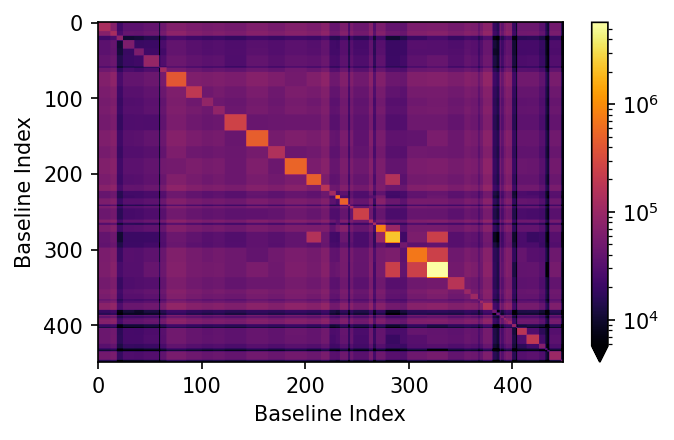

In [125]:
diff_cov = diff_mat @ diff_mat.T.conj()
cmap = plt.cm.inferno
norm = plt.cm.colors.LogNorm(vmin=1e-3*np.abs(diff_cov).max(), vmax=np.abs(diff_cov).max())
fig, ax = plt.subplots(1, 1, figsize=(5,3), dpi=150)
ax.set_xlabel("Baseline Index")
ax.set_ylabel("Baseline Index")
cax = ax.imshow(np.abs(diff_cov), aspect='auto', cmap=cmap, norm=norm)
fig.colorbar(cax, ax=ax, extend="min")
fig.savefig("diffuse_covariance_example.png", dpi=150, bbox_inches="tight")

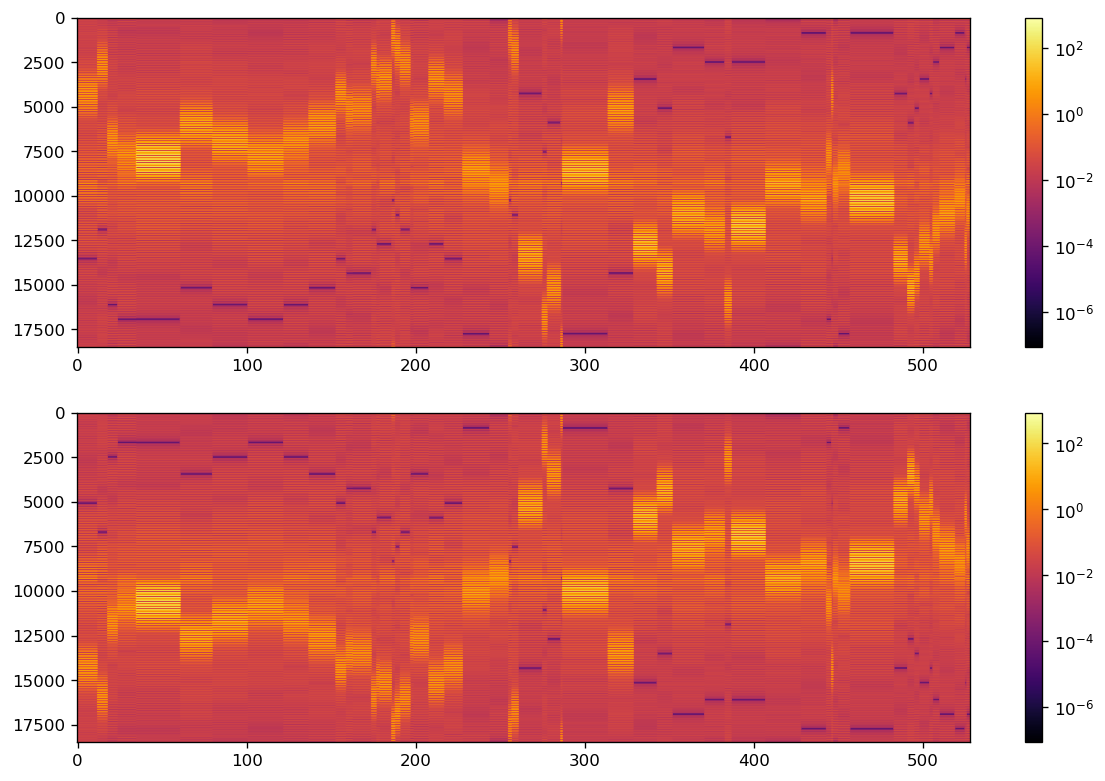

In [97]:
vmax = max(np.abs(diff_mat).max(), np.abs(alt_diff_mat).max())
vmin = min(np.abs(diff_mat).min(), np.abs(alt_diff_mat).min())
norm = plt.cm.colors.LogNorm(vmin=vmin, vmax=vmax)
fig, axes = plt.subplots(2,1,figsize=(12,8),dpi=120)
cax = axes[0].imshow(np.abs(diff_mat).T, aspect='auto', norm=norm, cmap='inferno')
fig.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(np.abs(alt_diff_mat).T, aspect='auto', norm=norm, cmap='inferno')
fig.colorbar(cax, ax=axes[1])

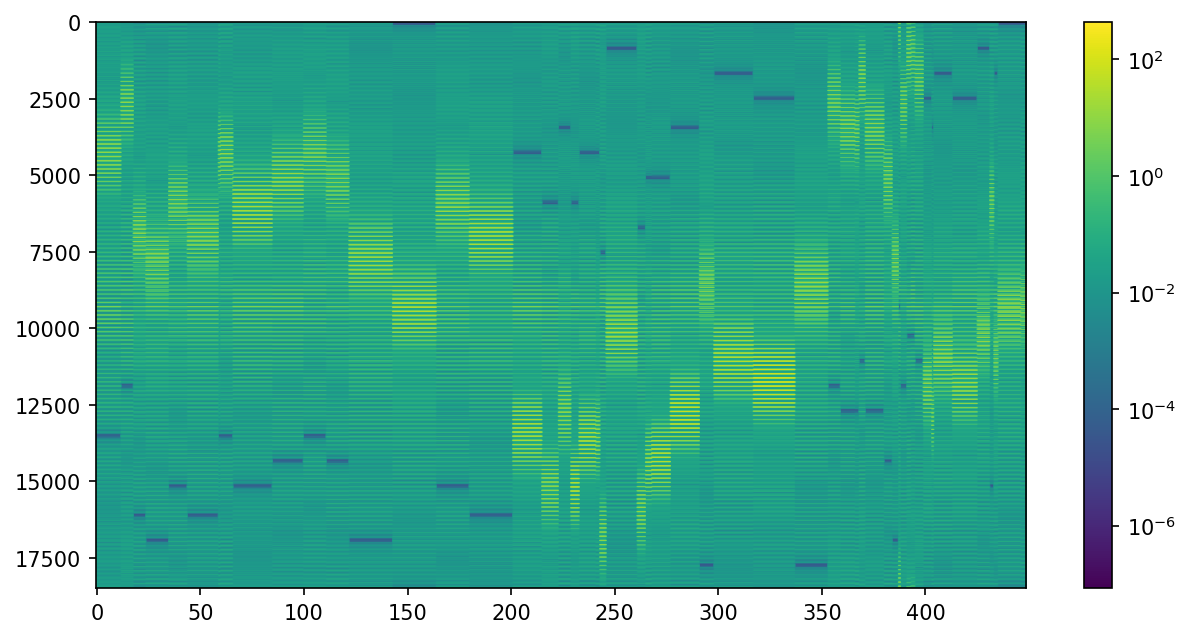

In [93]:
plt.figure(figsize=(10,5),dpi=150)
plt.imshow(np.abs(diff_mat).T,aspect='auto', norm=plt.cm.colors.LogNorm())
plt.colorbar()

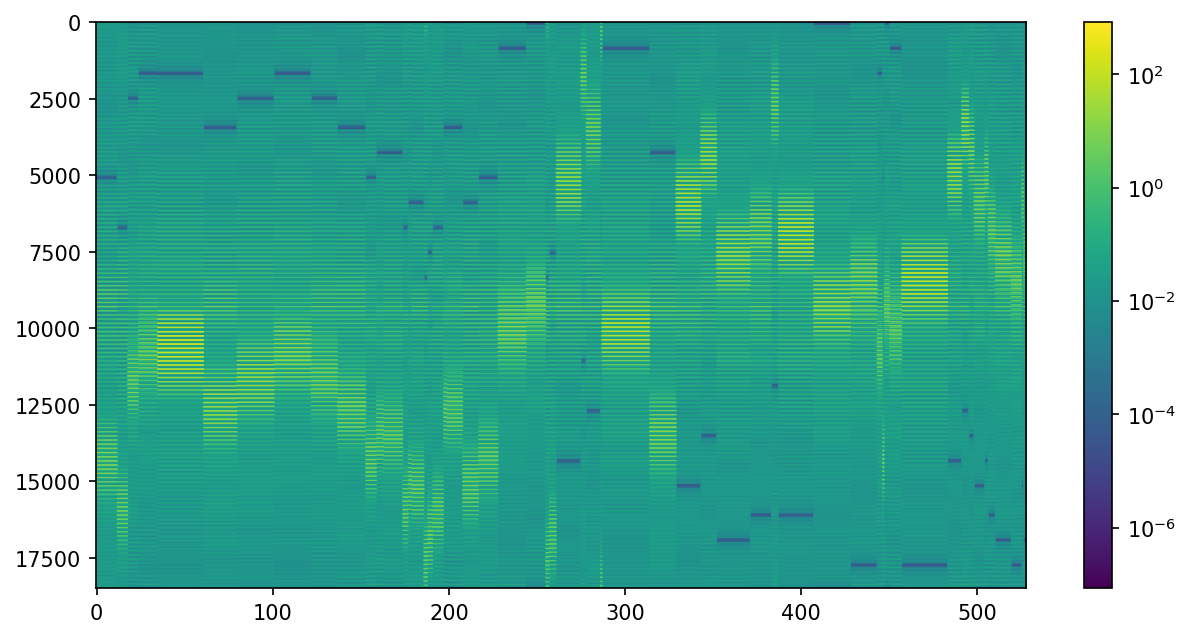

In [99]:
plt.figure(figsize=(10,5),dpi=150)
plt.imshow(np.abs(alt_diff_mat).T,aspect='auto', norm=plt.cm.colors.LogNorm())
plt.colorbar()

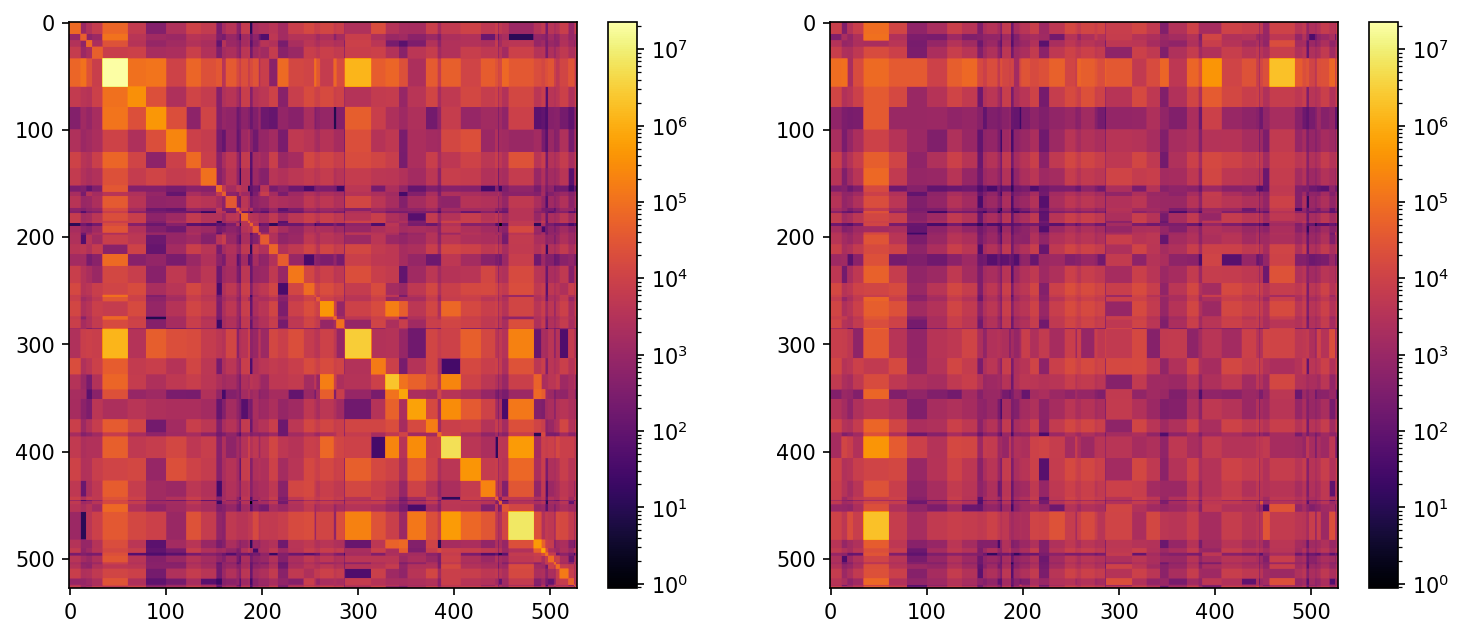

In [100]:
vmax = max(np.abs(diff_cov).max(), np.abs(diff_pcov).max())
vmin = min(np.abs(diff_cov).min(), np.abs(diff_pcov).min())
fig, axes = plt.subplots(1,2,figsize=(12,5),dpi=150)
cax = axes[0].imshow(np.abs(diff_cov), cmap='inferno', aspect='auto', norm=plt.cm.colors.LogNorm(vmin=vmin,vmax=vmax))
fig.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(np.abs(diff_pcov), cmap='inferno', aspect='auto', norm=plt.cm.colors.LogNorm(vmin=vmin,vmax=vmax))
fig.colorbar(cax, ax=axes[1])

In [101]:
ref = np.argmin(np.abs(u_samp))
this_cov = np.zeros((Nbls, Nbls), dtype=complex)
this_pseudocov = np.zeros((Nbls, Nbls), dtype=complex)
t1 = time.time()
for i, antpair1 in enumerate(this_antpairs):
    for j, antpair2 in enumerate(this_antpairs):
        u1, v1 = sorted_uvws[i,:2]
        u2, v2 = sorted_uvws[j,:2]
        du1 = np.abs(u_samp - u1)
        dv1 = np.abs(u_samp - v1)
        du2 = np.abs(u_samp - u2)
        dv2 = np.abs(u_samp - v2)
        uv1_shift = np.array([np.argmin(du1), np.argmin(dv1)], dtype=int) - ref
        uv2_shift = np.array([np.argmin(du2), np.argmin(dv2)], dtype=int) - ref
        beam_1 = np.roll(beam_kernel, uv1_shift, axis=(0, 1))
        beam_2 = np.roll(beam_kernel, uv2_shift, axis=(0, 1))
        this_cov[i,j] = np.sum(sky_pspec * beam_1 * beam_2.conj())
        beam_1 = np.roll(beam_kernel, -uv1_shift, axis=(0,1))
        beam_2 = np.roll(beam_kernel, -uv2_shift, axis=(0,1))
        this_pseudocov[i,j] = np.sum(sky_delta * beam_1 * beam_2)
t2 = time.time()
print(f"Took {(t2 - t1) / 60:.2f} minutes.")

Took 2.31 minutes.


In [102]:
cov_here = np.zeros((2*Nbls, 2*Nbls), dtype=float)
cov_here[:Nbls,:Nbls] = 0.5 * np.real(this_cov + this_pseudocov)
cov_here[:Nbls,Nbls:] = 0.5 * np.imag(this_pseudocov - this_cov)
cov_here[Nbls:,:Nbls] = 0.5 * np.imag(this_cov + this_pseudocov)
cov_here[Nbls:,Nbls:] = 0.5 * np.real(this_cov - this_pseudocov)

In [103]:
cov_with_realistic_noise = cov_here + noise_variance * np.eye(cov_here.shape[0])
cinv_here = np.linalg.inv(cov_with_realistic_noise)
this_chisq = this_split_data @ cinv_here @ this_split_data
this_chisq

55034.4499753317

## $\chi^2$ and $\nabla \chi^2$

Calculating $\chi^2$ is relatively straightforward. Note that we have
  
$$
    \chi^2 = d^T C^{-1} d = \sum_{i,j} d_i \bigl[N + C^{\rm sky}\bigr]^{-1}_{ij} d_j, 
$$
where $C^{\rm sky}_{ij} = G_{ii} C^{\rm model}_{ij} G_{jj}^*$, with no sum implied by the repeated indices. The gradient of $\chi^2$ is a little messy, but here it is in parts. First, we can write
  
$$
    \partial_x \chi^2 = \tilde{d}^T \partial_x C \tilde{d},
$$
where $\tilde{d} = (N + C^{\rm sky})^{-1} d$, and the index $x$ refers to an antenna. The gradient of the covariance can be written like so:
  
$$
    \partial_x C = \frac{1}{2} 
        \begin{pmatrix}
            \partial_x {\rm Re}(\Sigma + \Gamma) & \partial_x {\rm Im}(\Sigma - \Gamma) \\
            \partial_x {\rm Im}(\Sigma + \Gamma) & \partial_x {\rm Re}(\Gamma - \Sigma)
        \end{pmatrix},
$$
where recall $\Gamma$ is the covariance of the complex model data and $\Sigma$ is the pseudo-covariance. Further note that $\Gamma = G^\dagger \Gamma_0 G$, with $\Gamma_0$ the covariance of the perfectly calibrated model visibilities and $G$ the gain matrix (and likewise for $\Sigma$). In order to write each term in the covariance gradient in a somewhat compact form, let's define the following terms:
  
$$
    \begin{align}
        A^\pm_{\xi} &\equiv {\rm Re} \xi {\rm Re} G \pm {\rm Im} \xi {\rm Im} G, \\
        \tilde{A} ^\pm_{\xi} &\equiv {\rm Im} \xi {\rm Re} G \pm {\rm Re} \xi {\rm Im} G, \\
        X^\pm_{\xi x} &\equiv {\rm Re} \xi \partial_x {\rm Re} G \pm {\rm Im} \xi \partial_x {\rm Im} G, \\
        \tilde{X} ^\pm_{\xi x} &\equiv {\rm Im} \xi \partial_x {\rm Re} G \pm {\rm Re} \xi \partial_x {\rm Im} G,
    \end{align}
$$
where $\xi$ is either the covariance or pseudo-covariance. With these definitions in hand, we can calculate the gradients of the real/imaginary parts of the (pseudo-)covariance:
  
$$
    \begin{align}
        \partial_x {\rm Re} \Gamma &= \partial_x {\rm Re} G A^+_{\Gamma_0} - \partial_x {\rm Im} G \tilde{A} ^-_{\Gamma_0} + {\rm Re} G X^+_{\Gamma_0 x} - {\rm Im} G \tilde{X} ^-_{\Gamma_0 x} \\
        \partial_x {\rm Re} \Sigma &= \partial_x {\rm Re} G A^-_{\Sigma_0} - \partial_x {\rm Im} G \tilde{A} ^+_{\Sigma_0} + {\rm Re} G X^-_{\Sigma_0 x} - {\rm Im} G \tilde{X} ^+_{\Sigma_0 x} \\
        \partial_x {\rm Im} \Gamma &= \partial_x {\rm Im} G A^+_{\Gamma_0} + \partial_x {\rm Re} G \tilde{A} ^-_{\Gamma_0} + {\rm Im} G X^+_{\Gamma_0 x} + {\rm Re} G \tilde{X} ^-_{\Gamma_0 x} \\
        \partial_x {\rm Im} \Sigma &= \partial_x {\rm Im} G A^-_{\Sigma_0} + \partial_x {\rm Re} G \tilde{A} ^+_{\Sigma_0} + {\rm Im} G X^-_{\Sigma_0 x} + {\rm Re} G \tilde{X} ^+_{\Sigma_0 x}
    \end{align}
$$
  
The last ingredient to calculating $\nabla\chi^2$ is calculating the derivatives $\partial_x G$. Since we're treating the real/imaginary parts of the per-antenna gains as independent variables, these are the variables we're taking the derivatives with respect to. In order to do this correctly, we need to be a little careful about how terms are defined. First, recall that the indices on any of the matrices involved here ($G, C, N, d$) index over <i>baselines</i>. Since the gain matrix $G$ is diagonal, it makes good sense to describe it with a single index, $b_{ij}$, where $G_{b_{ij}} = g_i g_j^*$. So we have
  
$$
\begin{align}
    {\rm Re} G_{b_{ij}} &= {\rm Re} g_i {\rm Re} g_j + {\rm Im} g_i {\rm Im} g_j \\
    {\rm Im} G_{b_{ij}} &= {\rm Im} g_i {\rm Re} g_j - {\rm Re} g_i {\rm Im} g_j.
\end{align}
$$


For notational simplicity, let $x_{R/I}$ represent the real/imaginary part of the gain for antenna $x$. The derivatives we're interested in, then, are
  
$$
\begin{align}
    \partial_{x_R} {\rm Re} G_{b_{ij}} &= {\rm Re}\bigl( g_i \delta_{xj} + g_j \delta_{xi} \bigr), \\
    \partial_{x_I} {\rm Re} G_{b_{ij}} &= {\rm Im}\bigl( g_i \delta_{xj} + g_j \delta_{xi} \bigr), \\
    \partial_{x_R} {\rm Im} G_{b_{ij}} &= {\rm Im}\bigl( g_i \delta_{xj} - g_j \delta_{xi} \bigr), \\
    \partial_{x_I} {\rm Im} G_{b_{ij}} &= {\rm Re}\bigl( g_j \delta_{xi} - g_i \delta_{xj} \bigr).
\end{align}
$$

Some notes on including proper normalization: suppose we form the following likelihood
  
$$
    \mathcal{L} \propto \bigl(\det(C)\bigr)^{-1/2} \exp\biggl( \frac{d^T C^{-1} d}{2}\biggr) = \bigl(\det(C)\bigr)^{-1/2} \exp\biggl(-\frac{1}{2}\chi^2\biggr).
$$
  
We find the best-fit value by maximizing the likelihood, or equivalently by minimizing the negative log-likelihood:
  
$$
    -\log\mathcal{L} = \chi^2 + \log\bigl(\det(C)\bigr).
$$
  
We'll need the gradient of this for our minimization routine. We've already calculated $\nabla\chi^2$ above, so now we just need to calculate the gradient of the second term. We can treat the covariance as a mapping from the real numbers to square matrices and thus employ Jacobi's Formula to quickly calculate the gradient of the second term:
  
$$
    \partial_x\log\bigl(\det(C)\bigr) = \frac{\det(C) {\rm tr}\bigl(C^{-1} \partial_x C\bigr)}{\det(C)} = {\rm tr}\bigl(C^{-1} \partial_x C\bigr)
$$
  
Thus the gradient of the negative log-likelihood is
  
$$
    -\partial_x\log\mathcal{L} = \partial_x \chi^2 + {\rm tr}\bigl(C^{-1} \partial_x C\bigr)
$$

In [104]:
def build_gain_matrix(gains, ant_1_inds, ant_2_inds):
    Nants = gains.size // 2
    Nbls = ant_1_inds.size
    re = slice(None, Nbls)
    im = slice(Nbls, None)
    small_re = slice(None, Nants)
    small_im = slice(Nants, None)
    gain_mat = np.zeros(2*ant_1_inds.size, dtype=float)
    gain_mat[re] = gains[small_re][ant_1_inds] * gains[small_re][ant_2_inds]
    gain_mat[re] += gains[small_im][ant_1_inds] * gains[small_im][ant_2_inds]
    gain_mat[im] = gains[small_im][ant_1_inds] * gains[small_re][ant_2_inds]
    gain_mat[im] -= gains[small_im][ant_2_inds] * gains[small_re][ant_1_inds]
    return gain_mat

In [105]:
def apply_gains(
    cov,
    gains,
    ant_1_inds,
    ant_2_inds,
):
    gain_mat = build_gain_matrix(gains, ant_1_inds, ant_2_inds)
    Nbls = ant_1_inds.size
    re = slice(None, Nbls)
    im = slice(Nbls, None)
    sky_cov = np.zeros_like(cov)
    tmp = -diagmul(gain_mat[re], diagmul(cov[im,re], gain_mat[im]))
    sky_cov[re,re] = tmp + tmp.T + (
        diagmul(gain_mat[re], diagmul(cov[re,re], gain_mat[re]))
        + diagmul(gain_mat[im], diagmul(cov[im,im], gain_mat[im]))
    )
    sky_cov[re,im] = (
        diagmul(gain_mat[re], diagmul(cov[re,im], gain_mat[re]))
        - diagmul(gain_mat[im], diagmul(cov[im,re], gain_mat[im]))
        + diagmul(gain_mat[im], diagmul(cov[re,re], gain_mat[re]))
        - diagmul(gain_mat[im], diagmul(cov[im,im], gain_mat[re])).T
    )
    sky_cov[im,re] = sky_cov[re,im].T
    tmp = diagmul(gain_mat[re], diagmul(cov[re,im], gain_mat[im]))
    sky_cov[im,im] = tmp + tmp.T + (
        diagmul(gain_mat[re], diagmul(cov[im,im], gain_mat[re]))
        + diagmul(gain_mat[im], diagmul(cov[re,re], gain_mat[im]))
    )
    return sky_cov

In [106]:
def calc_chisq(
    gains,
    data,
    full_cov,
    noise,
    ant_1_array,
    ant_2_array,
    norm="inv_cov",
    ret_norm=False,
):
    antenna_numbers = set(ant_1_array.tolist()).union(
        set(ant_2_array.tolist())
    )
    antenna_numbers = list(antenna_numbers)
    ant_1_inds = np.zeros_like(ant_1_array)
    ant_2_inds = np.zeros_like(ant_2_array)
    for i, ant in enumerate(antenna_numbers):
        ant_1_inds[ant_1_array == ant] = i
        ant_2_inds[ant_2_array == ant] = i
    Nants = len(antenna_numbers)
    gain_mat = build_gain_matrix(gains, ant_1_inds, ant_2_inds)
    
    # TODO: change this to use Sparse2Level class
    sky_cov = apply_gains(full_cov, gains, ant_1_inds, ant_2_inds)
    inv_cov = np.linalg.inv(noise + sky_cov)
    scaled_data = vecmul(inv_cov, data)
    if norm == "inv_cov":
        # Calculating the determinant for such a big matrix is numerically unstable
        # So we'll exploit that log(det(A)) = tr(log(A))
        try:
            _norm = np.log(np.diag(np.linalg.cholesky(noise + sky_cov))).sum() * 2
        except np.linalg.LinAlgError:
            _norm = 1e10
#         _norm = np.log(np.linalg.det(noise + sky_cov))
    elif norm == "simple":
        _norm = gains[Nants:].sum() ** 2 + (gains[:Nants].sum() - Nants) ** 2
    elif norm in ("none", None):
        _norm = 0
    if ret_norm:
        return data @ scaled_data, _norm
    else:
        return data @ scaled_data + _norm

In [107]:
def calc_chisq_gradient(
    gains,
    data,
    cov,
    noise,
    ant_1_array,
    ant_2_array,
    scale=1e-5,
    norm="inv_cov",
):
    """Calculate the chi-squared gradient w.r.t. antenna gains.
    
    Parameters
    ----------
    data
        Vector containing the data, with the first half the real
        component and the second half the imaginary component.
    cov
        Covariance matrix of the real/imaginary split data. The
        upper-left block is the real part of the sum of the complex
        covariance and pseudo-covariance. The upper-right block is
        the imaginary part of the difference of the complex pseudo-
        covariance and covariance. The lower-left block is the imaginary
        part of the sum of the complex covaraince and pseudo-covariance.
        The lower-right block is the real part of the difference of the
        complex covariance and pseudo-covariance.
    noise
        Matrix describing thermal noise variance in the data.
    gains
        Array of per-antenna gains, separated into real and imaginary
        parts. These should be sorted in order of increasing antenna
        number, with the real part in the first half of the array and
        the imaginary part in the second half of the array.
    ant_1_array
        Array giving the first antenna for each visibility in the data.
    ant_2_array
        Array giving the second antenna for each visibility in the data.
    scale
        Scaling factor to multiply the gradient by before returning.
        
    Returns
    -------
    chisq_gradient
        Gradient of chi-squared with respect to the per-antenna gains.
        The array is sorted the same way that the ``gains`` are sorted.
    """
    antenna_numbers = set(ant_1_array.tolist()).union(
        set(ant_2_array.tolist())
    )
    antenna_numbers = list(antenna_numbers)
    ant_1_inds = np.zeros_like(ant_1_array)
    ant_2_inds = np.zeros_like(ant_2_array)
    for i, ant in enumerate(antenna_numbers):
        ant_1_inds[ant_1_array == ant] = i
        ant_2_inds[ant_2_array == ant] = i
    Nbls = ant_1_array.size
    Nants = len(antenna_numbers)
    re = slice(None, Nbls)
    im = slice(Nbls, None)
    chisq_gradient = np.zeros_like(gains)
    gain_mat = build_gain_matrix(gains, ant_1_inds, ant_2_inds)
    small_re = slice(None, Nants)
    small_im = slice(Nants, None)
    
    # TODO: change this to use Sparse2Level class
    sky_cov = apply_gains(cov, gains, ant_1_inds, ant_2_inds)
    inv_cov = np.linalg.inv(noise + sky_cov)
    del sky_cov
    scaled_data = vecmul(inv_cov, data)
    
    # Calculate the 8 unique matrix products here
    # Note that this is a very memory hungry thing to do and scales like Nant^4
#     t1 = time.time()
    re_gain_re_cov = diagmul(gain_mat[re], cov[re,re])
    im_gain_im_cov = diagmul(gain_mat[im], cov[im,im])
    re_gain_ir_cov = diagmul(gain_mat[re], cov[im,re])
    im_gain_ri_cov = diagmul(gain_mat[im], cov[re,im])
    re_gain_im_cov = diagmul(gain_mat[re], cov[im,im])
    im_gain_re_cov = diagmul(gain_mat[im], cov[re,re])
    im_gain_ir_cov = diagmul(gain_mat[im], cov[im,re])
    re_gain_ri_cov = diagmul(gain_mat[re], cov[re,im])
    
    
#     t2 = time.time()
#     print(f"Took {t2-t1} seconds to construct all A matrices.")
    
    # Now calculate the gradient for each antenna.
    for i, ant in enumerate(antenna_numbers):
        for j in (0, 1):  # Deriv w.r.t real/imag
            cov_gradient = np.zeros_like(cov)
#             t1 = time.time()
            here = (slice(None, Nants), slice(Nants, None))[j]
            # Calculate the derivative of G for the real/imag parts
            gain_deriv = np.zeros_like(data)
            
            # Do this the unga-bunga way bc I'm unga-bunga-ing
#             t1 = time.time()
            for k, (ai, aj) in enumerate(zip(ant_1_array, ant_2_array)):
                if ant == ai:
                    other_ant_ind = antenna_numbers.index(aj)
                    im_sign = 1 if j else -1
                elif ant == aj:
                    other_ant_ind = antenna_numbers.index(ai)
                    im_sign = -1 if j else 1
                else:
                    continue
                gain_deriv[re][k] = gains[(small_re,small_im)[j]][other_ant_ind]
                gain_deriv[im][k] = gains[(small_im,small_re)[j]][other_ant_ind] * (
                    im_sign
                )
#             t2 = time.time()
#             print(f"Took {t2-t1} seconds to differentiate gain matrix.")
            # Now fill in the different parts of the gradient
#             t1 = time.time()
            # Top-left section of covariance matrix
            cov_gradient[re,re] = (
                diagmul(re_gain_re_cov, gain_deriv[re]) + diagmul(im_gain_im_cov, gain_deriv[im])
                - diagmul(re_gain_ir_cov, gain_deriv[im]) - diagmul(im_gain_ri_cov, gain_deriv[re])
            )
            cov_gradient[re,re] = cov_gradient[re,re] + cov_gradient[re,re].T
        
            # Top-right section
            cov_gradient[re,im] = (
                diagmul(re_gain_ir_cov, gain_deriv[re]).T + diagmul(re_gain_ri_cov, gain_deriv[re])
                - diagmul(im_gain_ri_cov, gain_deriv[im]).T - diagmul(im_gain_ir_cov, gain_deriv[im])
                + diagmul(re_gain_re_cov, gain_deriv[im]).T + diagmul(im_gain_re_cov, gain_deriv[re])
                - diagmul(im_gain_im_cov, gain_deriv[re]).T - diagmul(re_gain_im_cov, gain_deriv[im])
            )
            cov_gradient[im,re] = cov_gradient[re,im].T
            
            # Bottom-right section
            cov_gradient[im,im] = (
                diagmul(re_gain_im_cov, gain_deriv[re]) + diagmul(im_gain_re_cov, gain_deriv[im])
                + diagmul(im_gain_ir_cov, gain_deriv[re]) + diagmul(re_gain_ri_cov, gain_deriv[im])
            )
            cov_gradient[im,im] = cov_gradient[im,im] + cov_gradient[im,im].T
            
#             t2 = time.time()
#             print(f"Took {t2-t1} seconds to differentiate covariance.")
            # Shove it into the covariance derivative
            # Then calculate this component of the gradient
            if norm == "inv_cov":
                _norm = np.diag(inv_cov @ cov_gradient).sum()
            elif norm == "simple":
                if j:
                    _norm = 2 * gains[Nants:].sum()
                else:
                    _norm = 2 * (gains[:Nants].sum() - Nants)
            elif norm in ("none", None):
                _norm = 0
            chisq_gradient[here][i] = scaled_data @ vecmul(
                cov_gradient, scaled_data
            ) + _norm

    return scale * chisq_gradient

In [108]:
test_cov = np.zeros_like(cov_here)
re = (slice(0,Nbls),)*2
im = (slice(Nbls,None),)*2
for i1, i2 in zip(edges[:-1], edges[1:]):
    test_cov[re][i1:i2,i1:i2] = cov_here[re][i1:i2,i1:i2]
    test_cov[im][i1:i2,i1:i2] = cov_here[im][i1:i2,i1:i2]

In [109]:
# Some sanity checks on asymptotic behavior of chisq

In [110]:
antenna_nums = np.unique(this_antpairs)
Nants = antenna_nums.size
ant_1_array, ant_2_array = this_antpairs.T
ant_1_inds = np.zeros_like(sim.data.ant_1_array)
ant_2_inds = np.zeros_like(sim.data.ant_2_array)
for i, ant in enumerate(antenna_nums):
    ant_1_inds[ant_1_array==ant] = i
    ant_2_inds[ant_2_array==ant] = i

In [111]:
eigvals = np.linalg.eigvalsh(cov_here)
noise_levels = np.logspace(-5,2,100) * eigvals.max()
chisq_vals, norm_vals, simple_norm_vals = [], [], []
ref_gains = np.ones(2 * Nants, dtype=float)
ref_gains[Nants:] = 0
for noise_level in noise_levels:
    chisq, norm = calc_chisq(
        ref_gains,
        this_split_data,
        cov,
        np.eye(2*ant_1_array.size) * noise_level,
        ant_1_array,
        ant_2_array,
        norm='inv_cov',
        ret_norm=True,
    )
    chisq_vals.append(chisq)
    norm_vals.append(norm)
    _, norm = calc_chisq(
        ref_gains,
        this_split_data,
        cov,
        np.eye(2*ant_1_array.size) * noise_level,
        ant_1_array,
        ant_2_array,
        norm='simple',
        ret_norm=True,
    )
    simple_norm_vals.append(norm)

NameError: name 'cov' is not defined

In [ ]:
approx_condition_numbers = eigvals.max() / noise_levels
fig, ax = plt.subplots(1,1,figsize=(8,3),dpi=150)
ax.set_xlabel("Noise Level [Jy]")
ax.set_ylabel(r"Contribution to $-\log\mathcal{L}$")
ax.loglog(noise_levels, chisq_vals, label=r"$\chi^2$")
ax.loglog(noise_levels, norm_vals, label=r"$\log\det C$")
ax.loglog(noise_levels, simple_norm_vals, label="Simple Norm")
ax.legend()
twinax = ax.twiny()
twinax.set_xscale('log')
twinax.set_xlim(*ax.get_xlim())
twinax.set_xticks(ax.get_xticks()[2:-2])
twinax.set_xticklabels([f"{eigvals.max()/tick:1.0e}" for tick in ax.get_xticks()[2:-2]])
twinax.set_xlabel("Approximate Condition Number")
fig.savefig("likelihood_contribs_as_noise_inc.pdf", dpi=150, bbox_inches="tight")
fig.savefig("likelihood_contribs_as_noise_inc.png", dpi=150, bbox_inches="tight")

In [ ]:
gain_scales = np.logspace(-5, 2, 100)
chisq_vals, norm_vals, simple_norm_vals = [], [], []
ref_gains = np.ones(2 * Nants, dtype=float)
ref_gains[Nants:] = 0
for gain_scale in gain_scales:
    chisq, norm = calc_chisq(
        ref_gains * gain_scale,
        this_split_data,
        cov,
        np.eye(2*ant_1_array.size) * noise_variance,
        ant_1_array,
        ant_2_array,
        norm='inv_cov',
        ret_norm=True,
    )
    chisq_vals.append(chisq)
    norm_vals.append(norm)
    _, norm = calc_chisq(
        ref_gains * gain_scale,
        this_split_data,
        cov,
        np.eye(2*ant_1_array.size) * noise_variance,
        ant_1_array,
        ant_2_array,
        norm='simple',
        ret_norm=True,
    )
    simple_norm_vals.append(norm)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,3),dpi=150)
ax.set_xlabel("Gain Amplitude")
ax.set_ylabel(r"Contribution to $-\log\mathcal{L}$")
ax.loglog(gain_scales, chisq_vals, label=r"$\chi^2$")
ax.loglog(gain_scales, norm_vals, label=r"$\log\det C$")
ax.loglog(gain_scales, simple_norm_vals, label="Simple Norm")
ax.legend()
fig.savefig("likelihood_contribs_as_gains_increase.pdf", dpi=150, bbox_inches="tight")
fig.savefig("likelihood_contribs_as_gains_increase.png", dpi=150, bbox_inches="tight")

In [ ]:
gain_phases = np.linspace(-np.pi, np.pi, 100)
chisq_vals, norm_vals = [], []
ref_gains = np.ones(2 * Nants, dtype=float)
ref_gains[Nants:] = 0
for gain_phase in gain_phases:
    gains = np.zeros_like(ref_gains)
    gains[:Nants] = np.cos(gain_phase) * ref_gains[:Nants]
    gains[Nants:] = np.sin(gain_phase) * ref_gains[:Nants]
    chisq, norm = calc_chisq(
        gains,
        this_split_data,
        cov,
        np.eye(2*ant_1_array.size) * noise_variance,
        ant_1_array,
        ant_2_array,
        norm='inv_cov',
        ret_norm=True,
    )
    chisq_vals.append(chisq)
    norm_vals.append(norm)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,3),dpi=150)
ax.set_xlabel("Gain Phase")
ax.set_ylabel(r"Contribution to $-\log\mathcal{L}$")
ax.plot(gain_phases, chisq_vals, label=r"$\chi^2$")
ax.plot(gain_phases, norm_vals, label="Normalization")
ax.legend()

In [ ]:
gain_slopes = np.logspace(-5,2,100)
chisq_vals, norm_vals = [], []
ref_gains = np.ones(2 * Nants, dtype=float)
ref_gains[Nants:] = 0
for gain_slope in gain_slopes:
    gains = ref_gains * (1 + gain_slope * np.linspace(0, 2, ref_gains.size))
    chisq, norm = calc_chisq(
        gains,
        this_split_data,
        cov,
        np.eye(2*ant_1_array.size) * noise_variance,
        ant_1_array,
        ant_2_array,
        norm='inv_cov',
        ret_norm=True,
    )
    chisq_vals.append(chisq)
    norm_vals.append(norm)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,3),dpi=150)
ax.set_xlabel("Gain Slope")
ax.set_ylabel(r"Contribution to $-\log\mathcal{L}$")
ax.loglog(gain_slopes, chisq_vals, label=r"$\chi^2$")
ax.loglog(gain_slopes, norm_vals, label="Normalization")
ax.legend()

In [ ]:
phase_slopes = np.logspace(-5,2,100)
chisq_vals, norm_vals = [], []
ref_gains = np.ones(2 * Nants, dtype=float)
ref_gains[Nants:] = 0
for phase_slope in phase_slopes:
    gains = np.zeros_like(ref_gains)
    gains[:Nants] = np.cos(np.pi * phase_slope * this_antpos[:,0] / 100)
    gains[Nants:] = np.sin(np.pi * phase_slope * this_antpos[:,0] / 100)
    chisq, norm = calc_chisq(
        gains,
        this_split_data,
        cov,
        np.eye(2*ant_1_array.size) * noise_variance,
        ant_1_array,
        ant_2_array,
        norm='inv_cov',
        ret_norm=True,
    )
    chisq_vals.append(chisq)
    norm_vals.append(norm)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,3),dpi=150)
ax.set_xlabel("Phase Slope")
ax.set_ylabel(r"Contribution to $-\log\mathcal{L}$")
ax.loglog(phase_slopes, chisq_vals, label=r"$\chi^2$")
ax.loglog(phase_slopes, norm_vals, label="Normalization")
ax.legend()

In [ ]:
Nants = uvdata_autos.Nants_data
gains = np.zeros(2 * Nants, dtype=float)
gains[:Nants] = np.random.normal(loc=1,scale=0.5,size=Nants)# * sim_gains.real
gains[Nants:] = np.random.normal(loc=0,scale=0.5,size=Nants)# * sim_gains.imag
noise=np.eye(this_split_data.size) * noise_variance
t1 = time.time()
chisq_gradient = calc_chisq_gradient(
    gains=gains,
    data=this_split_data,
    cov=test_cov,
    noise=np.eye(this_split_data.size) * noise_variance,
    ant_1_array=this_antpairs[:,0],
    ant_2_array=this_antpairs[:,1],
    scale=1e-5,
)
t2 = time.time()
print(f"Gradient calculation took {t2-t1} seconds.")
t1 = time.time()
fit_gains = fmin_cg(
    calc_chisq,
    gains,
    fprime=calc_chisq_gradient,
    args=(this_split_data,test_cov,noise,this_antpairs[:,0],this_antpairs[:,1]),
    maxiter=10,
    full_output=False,
    retall=False,
)
t2 = time.time()
dt = (t2 - t1) / 60
print(f"Minimization routine finished after {dt} minutes.")

In [ ]:
plt.figure(figsize=(8,3),dpi=150)
plt.plot(fit_gains[:Nants])
plt.plot(fit_gains[Nants:])
plt.plot(gains[:Nants],ls=':')
plt.plot(gains[Nants:],ls=':')

In [ ]:
plt.figure(figsize=(10,7),dpi=150)
plt.plot(chisq_gradient[:Nants],color='k',marker='o',lw=0,ms=0.75)
plt.plot(chisq_gradient[Nants:],color='r',marker='o',lw=0,ms=0.75)
plt.plot(gains[:Nants]-1,color='k',ls='--',marker='+',lw=0,ms=3.5)
plt.plot(gains[Nants:],color='r',ls='--',marker='+',lw=0,ms=3.5)
plt.axhline(0,ls=':',lw=0.5)
# plt.axhline(chisq_gradient[:Nants].mean(),ls=':',color='k')
# plt.axhline(chisq_gradient[Nants:].mean(),ls=':',color='r')
# plt.ylim(-1,1)

In [ ]:
avg_errors = np.array([0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001])
initial_guesses = []
best_fits = []
noise=np.eye(this_split_data.size) * noise_variance
for avg_error in avg_errors:
    gains = np.zeros(2 * Nants, dtype=float)
    gains[:Nants] = np.random.normal(loc=1,scale=avg_error,size=Nants)
    gains[Nants:] = np.random.normal(loc=0,scale=avg_error,size=Nants)
    initial_guesses.append(gains)
    t1 = time.time()
    fit_gains = fmin_cg(
        calc_chisq,
        gains,
        fprime=calc_chisq_gradient,
        args=(this_split_data,test_cov,noise,this_antpairs[:,0],this_antpairs[:,1]),
        maxiter=10,
        full_output=False,
        retall=False,
    )
    t2 = time.time()
    dt = (t2 - t1) / 60
    print(f"Routine done in {dt} minutes for error {avg_error}")
    best_fits.append(fit_gains)

In [ ]:
offset = 0
cmap = plt.cm.gist_rainbow
norm = plt.cm.colors.LogNorm(vmin=avg_errors[offset:].min(),vmax=avg_errors[offset:].max())
smap = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
antenna_numbers = np.array(sorted(list(sim.antpos.keys())))
fig, ax = plt.subplots(1,1,figsize=(12,5),dpi=150)
ax.set_xlabel("Antenna Number")
ax.set_ylabel("Gain")
for i, avg_error in enumerate(avg_errors[offset:]):
    re_gain_sol = best_fits[i+offset][:Nants]
    im_gain_sol = best_fits[i+offset][Nants:]
    re_gain_init = initial_guesses[i+offset][:Nants]
    im_gain_init = initial_guesses[i+offset][Nants:]
    color = cmap(norm(avg_error))
    ax.plot(re_gain_init, color=color)
    ax.plot(re_gain_sol, color=color, ls=':')
    ax.plot(im_gain_init, color=color)
    ax.plot(im_gain_sol, color=color, ls=':')
cbar = fig.colorbar(smap, ax=ax)
cbar.set_label("Average Initial Gain Error")
cbar.set_ticks(avg_errors)
ax.axhline(1, color='k', ls='--')
ax.axhline(0, color='k', ls='--')
ax.set_xlim(0,Nants-1)
ax.set_ylim(-0.5,1.5)
ax.set_xticks(np.arange(Nants))
ax.set_xticklabels(antenna_numbers);

## Calculating the Point-Source Contributions

In [98]:
gleam_file = "gleam-120.02-127.34MHz-nf-76-pld.skyh5"
assert os.path.exists(gleam_file)

In [99]:
gleam_model = pyradiosky.SkyModel.from_skyh5(gleam_file)

In [100]:
gleam_model.spectral_type = "subband"
gleam_model.at_frequencies(np.array([ref_freq,]) * units.Hz)

In [101]:
ras = gleam_model.ra
decs = gleam_model.dec
fluxes = gleam_model.stokes[0,0,:]

In [102]:
# Roughly following steps in HERA Memo 46 to transform coords
modified_jd = sim.data.time_array[0] - 2400000.5
lat, lon, alt = sim.data.telescope_location_lat_lon_alt
lat = Angle(lat, unit=units.rad)
lon = Angle(lon, unit=units.rad)
obstime = Time(modified_jd, format="mjd", location=(lon, lat))
local_frame = AltAz(
    location=EarthLocation.from_geocentric(*sim.data.telescope_location, unit=units.m),
    obstime=obstime,
)
source_positions = SkyCoord(ra=ras, dec=decs, frame="icrs")
local_positions = source_positions.transform_to(local_frame)

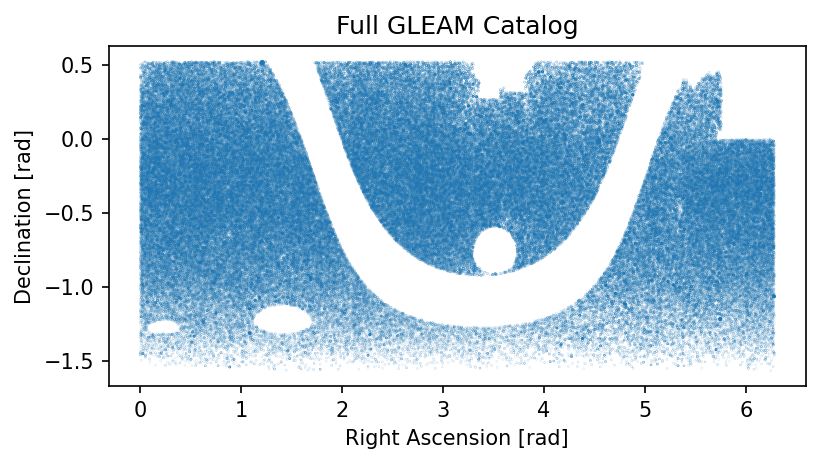

In [153]:
fig, ax = plt.subplots(1,1,figsize=(6,3),dpi=150)
ax.set_xlabel("Right Ascension [rad]")
ax.set_ylabel("Declination [rad]")
ax.set_title("Full GLEAM Catalog")
ax.scatter(gleam_model.ra.to("rad").value, gleam_model.dec.to("rad").value, s=np.abs(fluxes) / 100)
fig.savefig("input_source_catalog.png", dpi=150, bbox_inches="tight")

In [160]:
local_positions.alt.value.max()

89.82663060895283

In [161]:
local_positions.alt.value.min()

-88.73733890903726

In [151]:
beam = UVBeam()
beam.read_beamfits(str(beam_file))
beam.interpolation_function = 'az_za_simple'
beam.freq_interp_kind = 'cubic'
az = local_positions.az.to("rad").value
za = np.pi / 2 - local_positions.alt.to("rad").value
above_horizon = za <= np.pi / 2
is_bright = fluxes.to("Jy").value > 10
select = is_bright & above_horizon
interp_beam = beam.efield_to_power(
    calc_cross_pols=False, inplace=False
)
interp_beam.peak_normalize()
interp_beam = interp_beam.interp(
    az_array=az[select],
    za_array=za[select],
    freq_array=np.array([ref_freq]),
    polarizations=['xx',],
)[0][0,0,0,0]

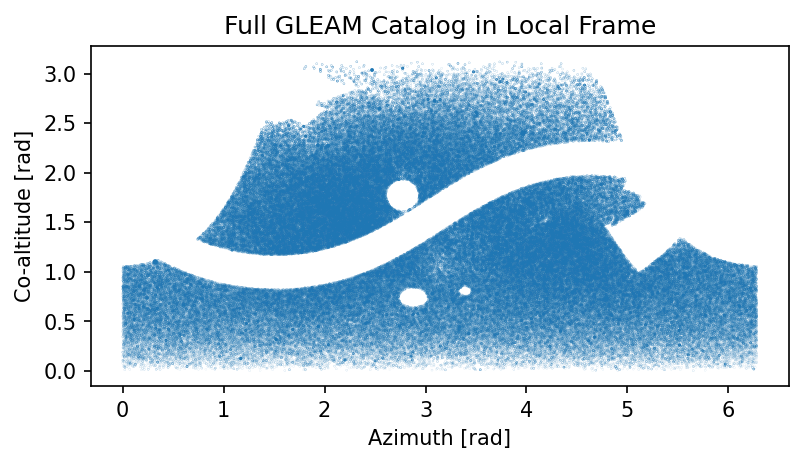

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(6,3), dpi=150)
ax.set_xlabel("Azimuth [rad]")
ax.set_ylabel("Co-altitude [rad]")
ax.set_title("Full GLEAM Catalog in Local Frame")
ax.scatter(az, za, s=np.abs(fluxes)/100)
fig.savefig("input_source_catalog_local_frame.png", dpi=150, bbox_inches="tight")

In [106]:
Nsrc = select.sum()
az_here = az[select]
za_here = za[select]
flux_here = fluxes[select]
src_cov = np.zeros((Nbls,Nbls), dtype=complex)
src_pcov = np.zeros_like(src_cov)
base_flux = (flux_here * interp_beam).value
phs_prefac = -2j * np.pi * ref_freq / const.c.si.value
directions = np.array(
    [
        [np.sin(z) * np.cos(a), np.sin(z) * np.sin(a), np.cos(z)]
        for z, a in zip(za_here, az_here)
    ]
)
positions = np.vstack(list(antpos.values()))
baselines = positions[ant_2_inds] - positions[ant_1_inds]
t1 = time.time()
src_mat = base_flux[None,:] * np.exp(phs_prefac * np.einsum("ik,jk->ij", baselines, directions))
src_cov = src_mat @ src_mat.T.conj()
src_pcov = src_mat @ src_mat.T
t2 = time.time()
print(f"Took {(t2-t1)/60} minutes.")

Took 0.0009012182553609212 minutes.


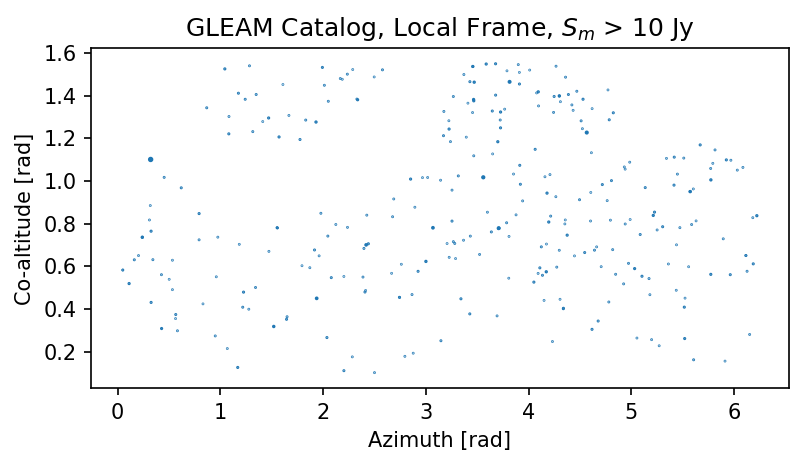

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(6,3), dpi=150)
ax.set_xlabel("Azimuth [rad]")
ax.set_ylabel("Co-altitude [rad]")
ax.set_title("GLEAM Catalog, Local Frame, $S_m$ > 10 Jy")
ax.scatter(az_here, za_here, s=np.abs(flux_here)/100)
fig.savefig("trimmed_source_catalog_local_frame.png", dpi=150, bbox_inches="tight")

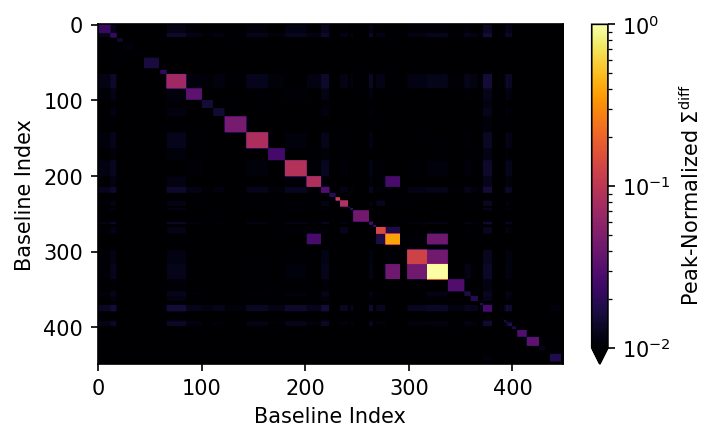

In [148]:
diff_cov = diff_mat @ diff_mat.T.conj()
normed_diff_cov = diff_cov / np.abs(diff_cov).max()
cmap = plt.cm.inferno
norm = plt.cm.colors.LogNorm(vmin=1e-2, vmax=None)
fig, ax = plt.subplots(1, 1, figsize=(5,3), dpi=150)
ax.set_xlabel("Baseline Index")
ax.set_ylabel("Baseline Index")
cax = ax.imshow(np.abs(normed_diff_cov), aspect='auto', cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, ax=ax, extend="min")
cbar.set_label(r"Peak-Normalized $\Sigma^{\rm diff}$")
fig.savefig("diffuse_covariance_example.png", dpi=150, bbox_inches="tight")

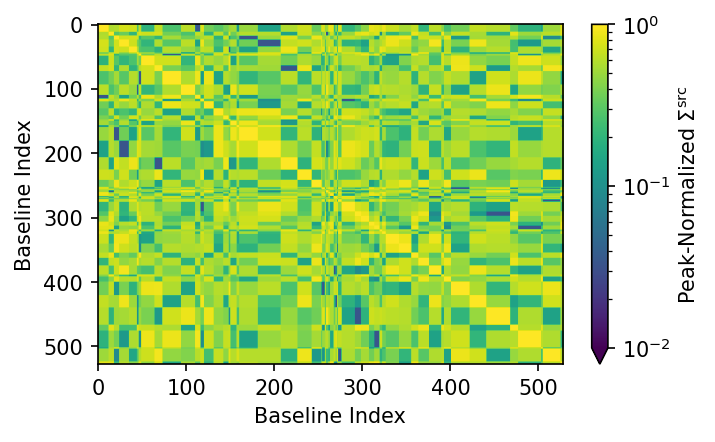

In [149]:
cmap = plt.cm.viridis
norm = plt.cm.colors.LogNorm(vmin=1e-2, vmax=None)
fig, ax = plt.subplots(1, 1, figsize=(5,3), dpi=150)
ax.set_xlabel("Baseline Index")
ax.set_ylabel("Baseline Index")
cax = ax.imshow(np.abs(src_cov)/np.abs(src_cov).max(), aspect='auto', cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, ax=ax, extend="min")
cbar.set_label(r"Peak-Normalized $\Sigma^{\rm src}$")
fig.savefig("source_covariance_example.png", dpi=150, bbox_inches="tight")

In [141]:
interp_beam = beam.efield_to_power(
    calc_cross_pols=False, inplace=False
)
interp_beam.peak_normalize()
interp_beam = interp_beam.interp(
    az_array=az[above_horizon],
    za_array=za[above_horizon],
    freq_array=np.array([ref_freq]),
    polarizations=['xx',],
)[0][0,0,0,0]

In [142]:
gridded_beam = np.zeros(ell.shape, dtype=interp_beam.dtype)
nsample_beam = np.zeros(ell.shape, dtype=int)
for i, (_az, _za) in enumerate(zip(az[above_horizon], za[above_horizon])):
    this_l = np.sin(_za) * np.cos(_az)
    this_m = np.sin(_za) * np.sin(_az)
    ell_dist = np.abs(ell - this_l)
    emm_dist = np.abs(emm - this_m)
    this_pixel = (ell_dist == ell_dist.min()) & (emm_dist == emm_dist.min())
    gridded_beam[this_pixel] += interp_beam[i]
    nsample_beam[this_pixel] += 1
gridded_beam[nsample_beam != 0] /= nsample_beam[nsample_beam != 0]
gridded_beam /= gridded_beam.max()

In [143]:
# Now get the uv kernel for the beam
beam_kernel = np.fft.fftshift(
    np.fft.fft2(gridded_beam)
) * np.mean(np.diff(l)) ** 2

In [ ]:
l = np.linspace(-1, 1, 101)
ell, emm = np.meshgrid(l, l, indexing="xy")

In [170]:
nsample = np.zeros(ell.shape, dtype=int)
gridded_I = np.zeros(ell.shape, dtype=float)
above_horizon = za <= np.pi / 2
pix_area = healpy.nside2pixarea(nside)
for i, intensity in enumerate(this_map.stokes[0,0]):
    if ~above_horizon[i]:
        continue
    this_l = np.sin(za[i]) * np.cos(az[i])
    this_m = np.sin(za[i]) * np.sin(az[i])
    ell_dist = np.abs(ell - this_l)
    emm_dist = np.abs(emm - this_m)
    this_pixel = (ell_dist == ell_dist.min()) & (emm_dist == emm_dist.min())
    gridded_I[this_pixel] += intensity.value * pix_area  # convert to flux, add to pixel
#     nsample[this_pixel] += 1
# gridded_I /= np.mean(np.diff(l)) ** 2  # back to intensity

In [172]:
I_fft = np.fft.fftshift(
    np.fft.fft2(gridded_I)
) * np.mean(np.diff(l)) ** 2

In [173]:
sky_pspec = np.abs(I_fft) ** 2
sky_delta = I_fft.real ** 2 - I_fft.imag ** 2

In [174]:
origin = np.array([np.abs(u_samp).min(),]*2)
uv = this_uvws[:,:2]
uv_shift = (uv - origin) / (u_samp[1] - u_samp[0])
uv_shift = np.around(uv_shift, 0).astype(int)
t1 = time.time()
diff_mat = np.zeros((Nbls, u_samp.size**2), dtype=complex)
alt_diff_mat = np.zeros_like(diff_mat)
for i, shift in enumerate(uv_shift):
    diff_mat[i] = np.roll(beam_kernel, shift, axis=(0,1)).flatten() * np.sqrt(sky_pspec).flatten()
    alt_diff_mat[i] = np.roll(beam_kernel, -shift, axis=(0,1)).flatten() * np.sqrt(sky_pspec).flatten()
diff_cov = diff_mat @ diff_mat.T.conj()
diff_pcov = diff_mat @ alt_diff_mat.T
t2 = time.time()
print(f"Took {(t2-t1)/60} minutes to make diffuse (pseudo)covariance.")

Took 0.014705344041188558 minutes to make diffuse (pseudo)covariance.


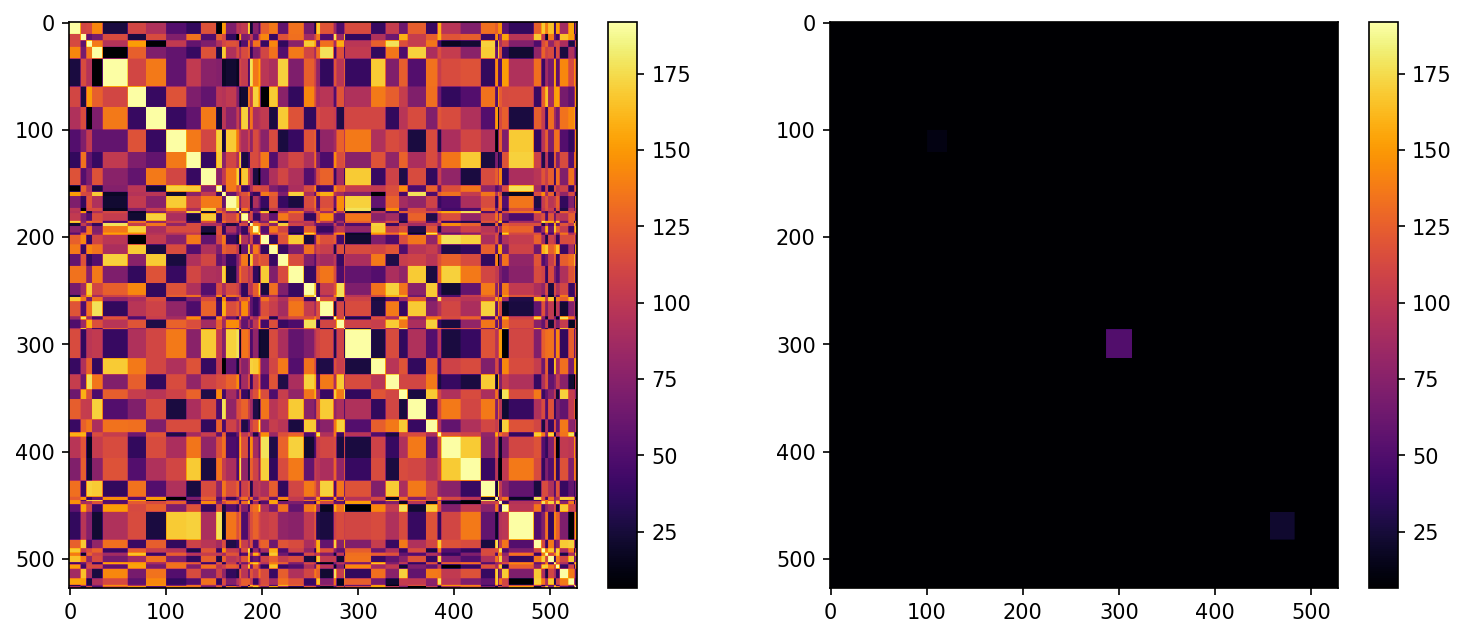

In [178]:
vmax = max(np.abs(src_cov).max(), np.abs(src_pcov).max())
vmin = min(np.abs(src_cov).min(), np.abs(src_pcov).min())
fig, axes = plt.subplots(1,2,figsize=(12,5),dpi=150)
cax = axes[0].imshow(np.abs(src_cov), vmin=vmin, vmax=vmax, cmap='inferno', aspect='auto')
fig.colorbar(cax, ax=axes[0])
cax = axes[1].imshow(np.abs(diff_cov), vmin=vmin, vmax=vmax, cmap='inferno', aspect='auto')
fig.colorbar(cax, ax=axes[1])

In [ ]:
src_contrib = np.zeros((2*Nbls, 2*Nbls), dtype=float)
src_contrib[:Nbls,:Nbls] = 0.5 * np.real(src_cov + src_pcov)
src_contrib[:Nbls,Nbls:] = 0.5 * np.imag(src_pcov - src_cov)
src_contrib[Nbls:,:Nbls] = 0.5 * np.imag(src_cov + src_pcov)
src_contrib[Nbls:,Nbls:] = 0.5 * np.real(src_cov - src_pcov)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), dpi=150)
cax = ax.imshow(src_contrib, aspect='auto', cmap='seismic', vmin=-src_contrib.max(), vmax=src_contrib.max())
cbar = fig.colorbar(cax)
ax.set_title("Model Point-Source Covariance", fontsize=12)
cbar.set_label("C [Jy$^2$]", fontsize=12)
ax.set_xlabel("Baseline Index", fontsize=12)
ax.set_ylabel("Baseline Index", fontsize=12)
ax.axhline(Nbls, ls=':', color='k')
ax.axvline(Nbls, ls=':', color='k')
fig.savefig(f"example_source_covariance_{Nsrc}_src.png", bbox_inches='tight', dpi=150)

In [ ]:
Nants = uvdata_autos.Nants_data
gains = np.zeros(2 * Nants, dtype=float)
gains[:Nants] = np.random.normal(loc=1,scale=0.1,size=Nants)# * sim_gains.real
gains[Nants:] = np.random.normal(loc=0,scale=0.1,size=Nants)# * sim_gains.imag
noise=np.eye(this_split_data.size) * noise_variance
t1 = time.time()
chisq_gradient = calc_chisq_gradient(
    gains=gains,
    data=this_split_data,
    cov=test_cov+src_contrib,
    noise=np.eye(this_split_data.size) * noise_variance,
    ant_1_array=this_antpairs[:,0],
    ant_2_array=this_antpairs[:,1],
)
t2 = time.time()
print(f"Gradient calculation took {t2-t1} seconds.")
t1 = time.time()
fit_gains = fmin_cg(
    calc_chisq,
    gains,
    fprime=calc_chisq_gradient,
    args=(this_split_data,test_cov+src_contrib,noise,this_antpairs[:,0],this_antpairs[:,1]),
    maxiter=10,
    full_output=False,
    retall=False,
)
t2 = time.time()
dt = (t2 - t1) / 60
print(f"Minimization routine finished after {dt} minutes.")

In [ ]:
plt.figure(figsize=(8,3),dpi=150)
plt.plot(fit_gains[:Nants], color='r', label="Real, Fit")
plt.plot(fit_gains[Nants:], color='k', label="Imag, Fit")
plt.plot(gains[:Nants],ls=':', color='r', label="Real, Guess")
plt.plot(gains[Nants:],ls=':', color='k', label="Imag, Guess")
plt.xlabel("Gain")
plt.ylabel("Antenna Number")
plt.legend(ncol=2)
# plt.savefig("example_gain_sol.png",dpi=150,bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,7),dpi=150)
plt.plot(chisq_gradient[:Nants],color='k',marker='o',lw=0,ms=0.75)
plt.plot(chisq_gradient[Nants:],color='r',marker='o',lw=0,ms=0.75)
plt.plot(gains[:Nants]-1,color='k',ls='--',marker='+',lw=0,ms=3.5)
plt.plot(gains[Nants:],color='r',ls='--',marker='+',lw=0,ms=3.5)
plt.axhline(0,ls=':',lw=0.5)
# plt.axhline(chisq_gradient[:Nants].mean(),ls=':',color='k')
# plt.axhline(chisq_gradient[Nants:].mean(),ls=':',color='r')
# plt.ylim(-1,1)

In [ ]:
raw_cov = src_mat @ src_mat.T.conj()# + diff_mat @ diff_mat.T.conj()
raw_pcov = src_mat @ src_mat.T# + diff_mat @ diff_mat[:,::-1].T
cov = np.zeros((2*Nbls,2*Nbls), dtype=float)
cov[:Nbls,:Nbls] = 0.5 * (raw_cov + raw_pcov).real
cov[:Nbls,Nbls:] = 0.5 * (raw_cov + raw_pcov).imag
cov[Nbls:,:Nbls] = 0.5 * (raw_pcov - raw_cov).imag
cov[Nbls:,Nbls:] = 0.5 * (raw_cov - raw_pcov).real
assert np.allclose(cov, cov.T)

In [ ]:
Nants = uvdata_autos.Nants_data
gains = np.zeros(2 * Nants, dtype=float)
gains[:Nants] = np.random.normal(loc=1,scale=0.05,size=Nants)# * sim_gains.real
gains[Nants:] = np.random.normal(loc=0,scale=0.05,size=Nants)# * sim_gains.imag
noise=np.eye(this_split_data.size) * noise_variance
t1 = time.time()
chisq_gradient = calc_chisq_gradient(
    gains=gains,
    data=this_split_data,
    cov=cov,
    noise=np.eye(this_split_data.size) * noise_variance,
    ant_1_array=this_antpairs[:,0],
    ant_2_array=this_antpairs[:,1],
    scale=5e-6,
    norm="inv_cov",
)
t2 = time.time()
print(f"Gradient calculation took {t2-t1} seconds.")
assert False
t1 = time.time()
fit_gains = fmin_cg(
    calc_chisq,
    gains,
    fprime=calc_chisq_gradient,
    args=(this_split_data,cov,noise,this_antpairs[:,0],this_antpairs[:,1]),
    maxiter=10,
    full_output=False,
    retall=False,
)
t2 = time.time()
dt = (t2 - t1) / 60
print(f"Minimization routine finished after {dt} minutes.")

In [151]:
beam_kernel.max()

(0.04951167239340995+0j)

In [ ]:
plt.figure(figsize=(8,3),dpi=150)
plt.plot(fit_gains[:Nants], color='r', label="Real, Fit")
plt.plot(fit_gains[Nants:], color='k', label="Imag, Fit")
plt.plot(gains[:Nants],ls=':', color='r', label="Real, Guess")
plt.plot(gains[Nants:],ls=':', color='k', label="Imag, Guess")
plt.xlabel("Gain")
plt.ylabel("Antenna Number")
plt.legend(ncol=2)
# plt.savefig("example_gain_sol.png",dpi=150,bbox_inches='tight')

In [ ]:
# norm_gains = np.zeros_like(gains)
# phase = np.arctan2(gains[0], gains[0])
# norm_gains[:Nants] = gains[:Nants] * np.cos(phase) + gains[Nants:] * np.sin(phase)
# norm_gains[Nants:] = gains[Nants:] * np.cos(phase) - gains[:Nants] * np.sin(phase)
norm_gains = gains.copy()
plt.figure(figsize=(10,7),dpi=150)
plt.plot(chisq_gradient[:Nants],color='k',marker='o',lw=1,ms=0.75)
plt.plot(chisq_gradient[Nants:],color='r',marker='o',lw=1,ms=0.75)
plt.plot(norm_gains[:Nants]-1,color='k',ls='--',marker='+',lw=1,ms=3.5)
plt.plot(norm_gains[Nants:],color='r',ls='--',marker='+',lw=1,ms=3.5)
plt.axhline(0,ls=':',lw=0.5)
# plt.axhline(chisq_gradient[:Nants].mean(),ls=':',color='k')
# plt.axhline(chisq_gradient[Nants:].mean(),ls=':',color='r')
# plt.ylim(-1,1)

In [ ]:
src_mat.shape, diff_mat.shape

In [127]:
# Just take a few sources
sigma = src_mat[:,:20]

# Need to put the diffuse matrix into its redundant form.
Nblocks = len(edges) - 1
Dmat = np.zeros((Nbls, Nblocks), dtype=complex)
for i, (start, stop) in enumerate(zip(edges, edges[1:])):
    amp = np.sqrt(diff_mat[start,:] @ diff_mat[start,:].conj())
    Dmat[start:stop,i] = amp
    
# Throw in the noise matrix
noise = np.eye(Nbls) * noise_variance

# Test that chi-squared calculated directly and with Woodbury inversion agree
cov = noise + sigma @ sigma.T.conj() + Dmat @ Dmat.T.conj()
cinv = np.linalg.inv(cov)
chisq_direct = this_data.conj() @ cinv @ this_data

# Now via Woodbury inversion
Ninv = np.eye(Nbls) / noise_variance
Nbar_inv = (
    Ninv  - Ninv @ sigma @ np.linalg.inv(
        np.eye(sigma.shape[1]) + sigma.T.conj() @ sigma
    ) @ sigma.T.conj() @ Ninv
)
Cinv = Nbar_inv - Nbar_inv @ Dmat @ np.linalg.inv(
    np.eye(Nblocks) + Dmat.T.conj() @ Nbar_inv  @ Dmat
) @ Dmat.T.conj() @ Nbar_inv
chisq_woodbury = this_data.conj() @ Cinv @ this_data
chisq = np.array([chisq_direct, chisq_woodbury])
assert np.isclose(chisq[0].real, chisq[1].real, rtol=1e-3)
assert np.allclose(chisq.imag, 0)

In [179]:
# Compare to the full thing
full_cov = noise + src_mat @ src_mat.T.conj() + diff_mat @ diff_mat.T.conj()
full_cinv = np.linalg.inv(full_cov)
chisq_full = this_data.conj() @ full_cinv @ this_data

In [176]:
np.mean(np.diff(l)) ** 2

0.00021947873799725654

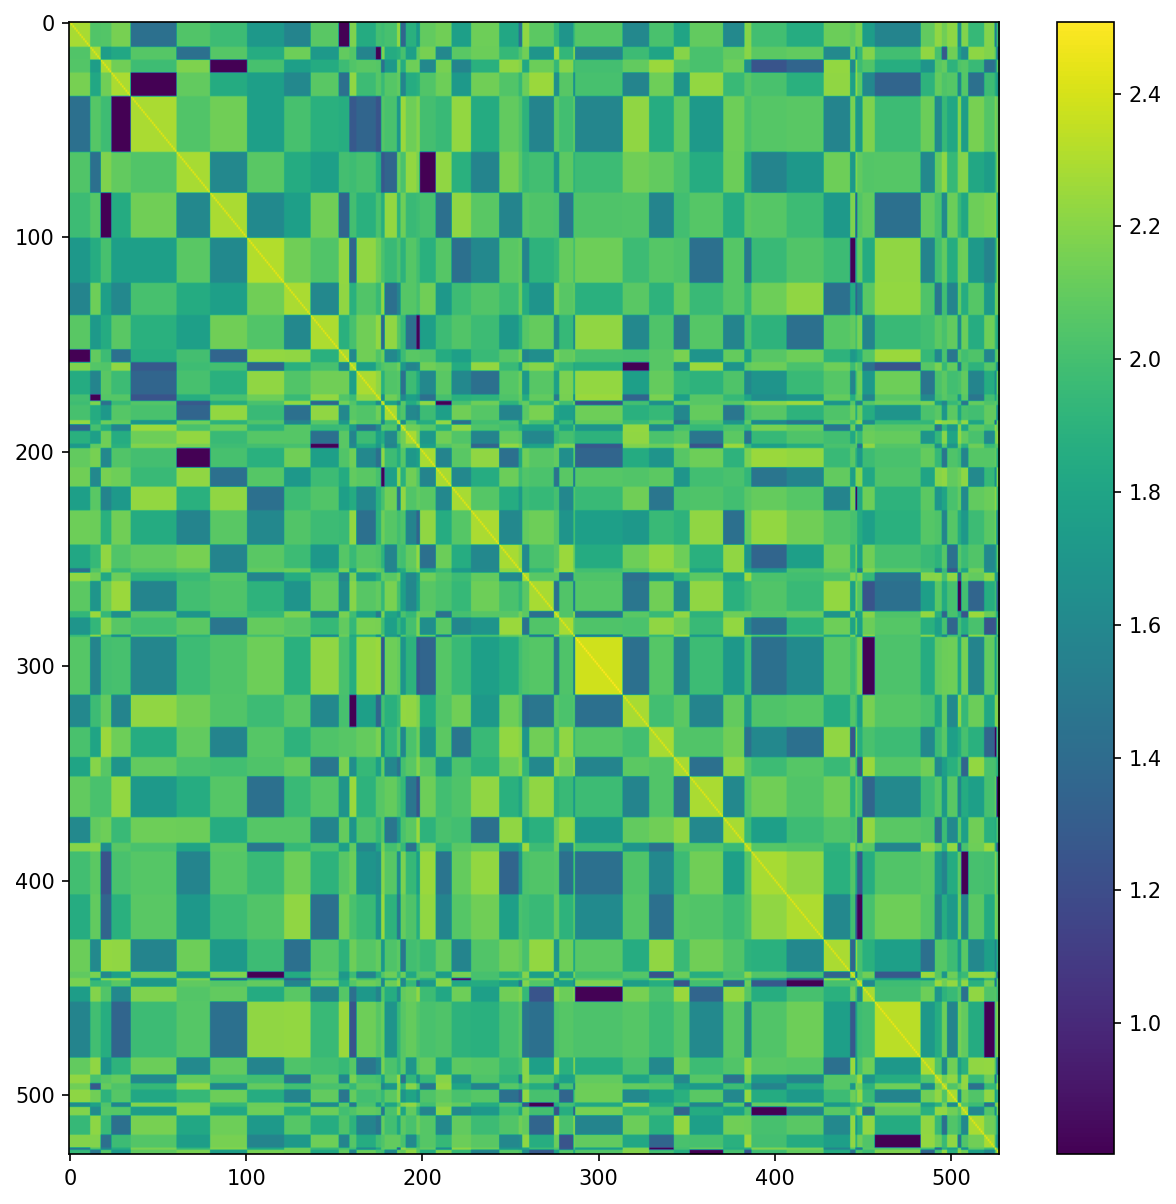

In [180]:
plt.figure(figsize=(10,10), dpi=150)
# plt.imshow(np.log10(np.abs(src_mat @ src_mat.T.conj())), aspect='auto')
plt.imshow(np.log10(np.abs(full_cov)), aspect='auto')
plt.colorbar()

### A few TODOs

* Write a simple $\chi^2$ routine using just the sky covariance like above.
* Calculate $\nabla\chi^2$ in this form and write a function to calculate it.
* See if inverting $N + \hat{D}\hat{D}^\dagger$ by redundant blocks is faster than just straight-up inverting it. Think about how this scales.
* See if just using this form of $\chi^2$ is able to reasonably calibrate the test data.
* Figure out the right way to construct the gridded diffuse intensity.

In [201]:
g = np.zeros(2*Nants,dtype=float)
g[:Nants] = 1
simple_grad_nll(data, noise + 1j*np.zeros_like(noise), full_cov, g, ant_1_inds, ant_2_inds)

array([ 7.04061596e+03,  6.98071540e+03,  7.25121799e+03,  6.78815379e+03,
        6.85605300e+03,  6.92969161e+03,  7.24019311e+03,  6.76603449e+03,
        6.21292332e+03,  6.55378577e+03,  6.53335080e+03,  6.88129029e+03,
        6.69510526e+03,  6.58913864e+03,  6.65129316e+03,  6.87358821e+03,
        6.51193413e+03,  6.82570572e+03,  7.01681675e+03,  6.63263230e+03,
        6.67220701e+03,  6.75100855e+03,  6.52162498e+03,  6.70952120e+03,
        7.01722720e+03,  7.19351730e+03,  7.02823589e+03,  6.65978656e+03,
        6.61194287e+03,  7.55151627e+03,  6.87797567e+03,  6.86642968e+03,
        6.86501706e+03,  5.47163214e+01, -8.42750290e+02,  6.17226637e+02,
       -7.49964405e+02, -4.36939480e+01, -3.81611318e+02,  4.12412698e+02,
        3.17016559e+02,  3.92307342e+00,  7.44367420e+01,  6.08713155e+02,
       -5.57854066e+02,  1.95954594e+02, -1.42480681e+02,  7.95485578e+02,
       -5.61764299e+01,  1.34905639e+02, -2.87615022e+02,  1.84622198e+02,
        1.86514180e+02,  

In [193]:
def build_gain_mat(gains, ant_1_inds, ant_2_inds):
    # Assume gains are real/im split, output complex gain matrix
    nants = gains.size // 2
    complex_gains = gains[:nants] + 1j * gains[nants:]
    return complex_gains[ant_1_inds] * complex_gains[ant_2_inds].conj()

In [197]:
def simple_nll(data, noise, cov, gains, ant_1_inds, ant_2_inds, norm="det"):
    """Simple chi-squared routine.
    
    Assumes relevant quantities are complex-valued, but gains are real-valued
    """
    gain_mat = build_gain_mat(gains, ant_1_inds, ant_2_inds)
    scaled_cov = diagmul(gain_mat, diagmul(cov, gain_mat.conj()))
    inv_cov = np.linalg.inv(noise + scaled_cov)
    # Split things up so that we're guaranteed chisq is real-valued
    Nants = gains.size // 2
    Nbls = data.size
    re = slice(None,Nbls)
    im = slice(Nbls,None)
    split_data = np.zeros(2*Nbls, dtype=float)
    split_data[re] = data.real
    split_data[im] = data.imag
    split_cinv = np.zeros((2*Nbls, 2*Nbls), dtype=float)
    split_cinv[re,re] = inv_cov.real
    split_cinv[re,im] = -inv_cov.imag
    split_cinv[im,re] = inv_cov.imag
    split_cinv[im,im] = inv_cov.real
    if norm == "det":
        try:
            chol = np.linalg.cholesky(scaled_cov)
            norm = 2 * np.log(np.diag(chol).real).sum()
        except np.linalg.LinAlgError:
            norm = 1e10
    elif norm == "simple":
            norm = gains[Nants:].sum() ** 2 + (gains[:Nants].sum() - Nants) ** 2
    else:
        raise NotImplementedError
    return split_data @ vecmul(split_cinv, split_data) + norm

In [199]:
def simple_grad_nll(data, noise, cov, gains, ant_1_inds, ant_2_inds, norm="det"):
    gain_mat = build_gain_mat(gains, ant_1_inds, ant_2_inds)
    nants = gains.size // 2
    complex_gains = gains[:nants] + 1j * gains[nants:]
    scaled_cov = diagmul(gain_mat, diagmul(cov, gain_mat.conj()))
    cinv = np.linalg.inv(noise + scaled_cov)
    scaled_data = vecmul(cinv, data)
    nvis = ant_1_inds.size
    grad_nll = np.zeros(2 * nants, dtype=float)
    for m in range(nants):
        for n in range(2):
            here = (slice(None,nants), slice(nants,None))[n]
            gain_mat_deriv = np.zeros_like(gain_mat)
            conj_gain_mat_deriv = np.zeros_like(gain_mat_deriv)
            if n == 0:
                # Derivative wrt real gain for ant m
                gain_mat_deriv[ant_1_inds==m] += np.conj(
                    complex_gains[ant_2_inds[ant_1_inds==m]]
                )
                gain_mat_deriv[ant_2_inds==m] += complex_gains[ant_1_inds[ant_2_inds==m]]
                conj_gain_mat_deriv[ant_1_inds==m] += complex_gains[ant_2_inds[ant_1_inds==m]]
                conj_gain_mat_deriv[ant_2_inds==m] += np.conj(
                    complex_gains[ant_1_inds[ant_2_inds==m]]
                )
            else:
                # Derivative wrt imag gain for ant m
                gain_mat_deriv[ant_1_inds==m] += 1j * np.conj(
                    complex_gains[ant_2_inds[ant_1_inds==m]]
                )
                gain_mat_deriv[ant_2_inds==m] -= 1j * complex_gains[ant_1_inds[ant_2_inds==m]]
                conj_gain_mat_deriv[ant_1_inds==m] -= 1j * complex_gains[ant_2_inds[ant_1_inds==m]]
                conj_gain_mat_deriv[ant_2_inds==m] += 1j * np.conj(
                    complex_gains[ant_1_inds[ant_2_inds==m]]
                )
            cov_deriv = diagmul(gain_mat_deriv, diagmul(cov, gain_mat.conj())) + diagmul(
                gain_mat, diagmul(cov, conj_gain_mat_deriv)
            )
            chisq_deriv = scaled_data.conj() @ vecmul(cov_deriv, scaled_data)
            if norm == "det":
                _norm = np.diag(cinv @ cov_deriv).sum()
            else:
                raise NotImplementedError
            grad_nll[here][m] = np.real(chisq_deriv + _norm)
    return grad_nll

In [113]:
def rephase_to_ant(complex_gains, ant=0):
    ref_gain = complex_gains[ant]
    conj_phase = ref_gain.conj() / np.abs(ref_gain)
    return complex_gains * conj_phase

In [ ]:
A = np.random.normal(size=(100,100)) + 1j * np.random.normal(size=(100,100))
A = A @ A.T.conj()
L = np.linalg.cholesky(A)
2 * np.log(np.diag(L).real).sum(), 2 * np.log(np.diag(L)).sum()

In [ ]:
np.all(np.diag(L) == np.diag(L).conj())

In [ ]:
np.log(np.linalg.det(A))

In [ ]:
np.allclose(L @ L.T.conj(), A)

In [ ]:
%%timeit
noise = np.eye(Nbls) * noise_variance
cov = noise + sigma @ sigma.T.conj() + Dmat @ Dmat.T.conj()
cinv = np.linalg.inv(cov)
chisq_direct = this_data.conj() @ cinv @ this_data

In [ ]:
%%timeit
Ninv = np.eye(Nbls) / noise_variance
Nbar_inv = (
    Ninv  - Ninv @ sigma @ np.linalg.inv(
        np.eye(sigma.shape[1]) + sigma.T.conj() @ sigma
    ) @ sigma.T.conj() @ Ninv
)
Cinv = Nbar_inv - Nbar_inv @ Dmat @ np.linalg.inv(
    np.eye(Nblocks) + Dmat.T.conj() @ Nbar_inv  @ Dmat
) @ Dmat.T.conj() @ Nbar_inv
chisq_woodbury = this_data.conj() @ Cinv @ this_data

TODOs:
* ~Apply a filter for sources above the horizon at whatever time I'm looking at.~
* ~Select the $\sim$10 brightest sources of the ones above the horizon.~
* ~Use these to build the point source contribution to the covariance.~
* Compare calibration results using only diffuse, only pntsrc, and both. Also vary normalization used.
* BIG TODO: Write the damn `covh5` filetype. Set aside a full day for this.
* BIG TODO: Write a basic pipeline with the existing tools. Assume the user provides data/covariance files.
* Graduate the code here to the sparse two-level representation. This means using only the redundant blocks from the diffuse part, the `(Nsrc,2Nbls)` point source matrix, and exploiting the hell out of the Woodbury identity and Cholesky decompositions.
* Rewrite the `Sparse2Level` class after having worked with things, then write the `CorrCal` class.
* See about updating the solver to a homebrew CG solver (or some other nonlinear minimizer).

## Setup

In [ ]:
# Load the data

In [ ]:
# Extract the required metadata

In [ ]:
# Sort everything by redundancy

## Run CorrCal

In [ ]:
# Set up the scipy conjugate gradient solver

In [ ]:
# Actually run the solver

## Analysis of Gain Solutions

Recall that in the redundant calibration limit, we expect there to be four degeneracies:
* Overall amplitude degeneracy
* Overall phase degeneracy
* Phase gradient degeneracy (x and y)
  
Show that, up to these degeneracies, the gain solutions are extracted perfectly (a stretch).

Additionally, verify that what we're calling the redundant calibration limit is equivalent in the sense that it has the same degeneracies. This isn't immediately obvious from staring at the covariance and chi-squared, but it might be possible to show this analytically.

In [ ]:
# Evaluate the quality of the gain solutions

In [ ]:
# Plots plots plots plots plots

# Load data and setup